In [2]:
import os
import random, os
import numpy as np
import torch

os.environ['CUDA_VISIBLE_DEVICES'] = "1"


def seed_everything(seed: int):
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import pytorch_lightning as pl
from sparsemax import Sparsemax


#torch.manual_seed(0)
#random.seed(0)
#np.random.seed(0)


class MultiheadAttention(pl.LightningModule):
    def __init__(
        self,
        max_t = 1, 
        softmax_factor = 1,
        number_of_heads = 1,
        num_filters = 10,
        **kwargs
    ):
        super(MultiheadAttention, self).__init__()

        self.max_t = max_t
        self.softmax_factor = softmax_factor
        self.number_of_heads = number_of_heads

        self.combine_time_dense = nn.Linear(num_filters, num_filters)

    def forward(self, latents, latents_frames):
        batch_size = latents.shape[0]
        timesteps = latents.shape[1]

        time_mask = self.mask(latents_frames, max_t=self.max_t)
        
        mask = time_mask

        eye = torch.eye(batch_size, dtype=torch.float32, device=time_mask.device)
        eye = eye.repeat_interleave(timesteps*latents.shape[2], dim=0)
        batch_mask = eye.repeat_interleave(timesteps*latents.shape[2], dim=1)

        #time_mask *= batch_mask
        
        # Edges between the supernodes:
        updated_latents, attention = self.multihead_time_attention(latents, self.softmax_factor, self.number_of_heads, mask)

        updated_latents = updated_latents.view(batch_size*timesteps, -1, updated_latents.shape[-1])

        return [updated_latents, attention]

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-5)
    
    def mask(self, supernode_times, max_t):
        supernode_times = supernode_times.view(-1, 1)
        m = torch.where(torch.abs(torch.transpose(supernode_times, 0, 1) - supernode_times) <= max_t, 1, 0)
        m = torch.where(torch.transpose(supernode_times, 0, 1) == supernode_times, torch.tensor(0, dtype=torch.int32), m)

        return m.float()
    
    def multihead_time_attention(self, latents, softmax_factor, number_of_heads, mask):

        number_of_filters = latents.shape[-1]

        projection_dim = number_of_filters // number_of_heads

        latents = latents.view(-1, number_of_heads, projection_dim)
        latents = latents.transpose(0, 1)

        nominator = torch.matmul(latents, latents.transpose(1, 2))
        denominator = torch.einsum('hi,hj->hij', torch.norm(latents, dim=2), torch.norm(latents, dim=2))

        attention = torch.div(nominator, denominator)  # Note: PyTorch's div function already handles division by zero
        attention += (1 - mask) * -10e9
        attention = torch.nn.functional.softmax(attention * softmax_factor, dim=-1)
        attention = torch.mean(attention, axis=0, keepdim=True)
        #attention = Sparsemax()(attention)

        add_eye = torch.eye(attention.shape[1], device=attention.device)
        updated_latents = torch.matmul(attention + add_eye, latents) / 2

        updated_latents = updated_latents.view(-1, number_of_filters)

        updated_latents = self.combine_time_dense(updated_latents)

        return updated_latents, attention

    def distance_matrix_heads(self, matrix_a, matrix_b):
        expanded_a = matrix_a.unsqueeze(2)
        expanded_b = matrix_b.unsqueeze(1)
        square_difference = torch.square(expanded_a - expanded_b)
        distances = torch.sum(square_difference, dim=3)
        distances = torch.sqrt(distances)

        return distances


class MultiEntityVariationalAutoEncoder(pl.LightningModule):
    def __init__(self, num_entities, beta=0.1, latent_dim=12, number_of_heads=1, softmax_tmp = 1):
        super(MultiEntityVariationalAutoEncoder, self).__init__()

        self.num_entities = num_entities
        self.beta = beta
        self.latent_dim = latent_dim

        actual_latent_dim = latent_dim * 2 

        self.time_attention = MultiheadAttention(number_of_heads=number_of_heads, num_entities=latent_dim-2, softmax_factor=softmax_tmp)

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(8, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, actual_latent_dim, 3, padding=1),
        )

        self.decoder_1 = nn.Sequential(
            nn.Conv2d(self.latent_dim + 1, 32, 1, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 32, 1, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 32, 1, padding=0),
        )

        self.decoder_2 = nn.Sequential(
            nn.Conv2d(32, 32, 1, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 32, 1, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 1, 1, padding=0),
        )

    

    def forward(self, x):
        true_batch_size = x.shape[0]
        timesteps = x.shape[1]

        batch_size = true_batch_size*timesteps

        x = x.view(batch_size, x.shape[2], x.shape[3], x.shape[4])

        y = self.encoder(x)

        mu = y[:, :self.latent_dim, :, :]
        logvar = y[:, self.latent_dim:, :, :]

        x_range = torch.arange(0, x.shape[3], device=x.device, dtype=torch.float32)
        y_range = torch.arange(0, x.shape[2], device=x.device, dtype=torch.float32)
        x_grid, y_grid = torch.meshgrid(x_range, y_range)

        std = torch.exp(0.5 * logvar)

        parametrization = torch.randn_like(std) * std + mu

        delta_xy_pred = parametrization[:, :2].view(batch_size, 2, -1)
        parametrization = parametrization[:, 2:].view(batch_size, self.latent_dim - 2, -1)
        

        # Calculate the KL divergence from the prior of gaussian distribution with mean 0 and std 1
        # to the posterior of the gaussian distribution with mean mu and std std
        # KL divergence is calculated as 0.5 * sum(1 + log(std^2) - mu^2 - std^2)

        kl_divergence = -0.5 * torch.sum(1 + logvar - mu**2 - std**2, dim=1)
        kl_divergence = kl_divergence.view(batch_size, -1)
        # find the i,j indices of the max value num_entities elements in the kl_divergence tensorimage_size
        # these indices will be used to select the num_entities most important entities

        top_kl_divergence, indices = torch.topk(kl_divergence, self.num_entities, dim=1)
        indices = indices.detach()
        intermediate_feature_map = None

        latents = torch.stack(
            [
                torch.stack(
                    [parametrization[batch_idx, :, idx] for idx in indices[batch_idx]]
                ) for batch_idx in range(batch_size)
            ]
        )

        
        times = torch.arange(0, timesteps, device=x.device, dtype=torch.int32)
        times = torch.unsqueeze(times.repeat(true_batch_size), -1).repeat(1, self.num_entities)

        times = times.view(true_batch_size, timesteps, latents.shape[1], -1)
        latents = latents.view(true_batch_size, timesteps, latents.shape[1], -1)

        latents, attention = self.time_attention(latents, times) # NOT SURE IF I SHOULD DO THIS HERE OR FURTHER DOWN

        # repeat latents to match the size of input image
        # (batch_size, num_entities, latent_dim, 1, 1) -> (batch_size, num_entities, latent_dim, x.shape[2], x.shape[3]
        latents = latents[:, :, :, None, None].repeat(1, 1, 1, x.shape[2], x.shape[3])

        # grid channel is a tensor of size (batch_size, latent_dim, 2, x.shape[2], x.shape[3])
        # it contains the x and y coordinates of each pixel in the image
        grid_channel = torch.stack([x_grid, y_grid])[None, None]
        grid_channel = grid_channel.repeat(batch_size, self.num_entities, 1, 1, 1)

        # center the grid channel around the coordinates of the entities
        x_coord = indices // y.shape[3]
        y_coord = indices % y.shape[3]
        
        # add 0.5 to the coordinates to center the grid channel around the coordinates of the entities
        # scale the coordinates to match the size of the input image
        x_coord = (x_coord + 0.5) * x.shape[2] / y.shape[2]
        y_coord = (y_coord + 0.5) * x.shape[3] / y.shape[3]

        xy_coord = torch.stack([x_coord, y_coord], dim=2)[..., None, None]
        grid_channel = grid_channel - xy_coord

        # add the predicted delta_xy to the grid channel
        pred_delta_xy = torch.stack(
            [
                torch.stack(
                    [delta_xy_pred[batch_idx, :, idx] for idx in indices[batch_idx]]
                ) for batch_idx in range(batch_size)
            ]
        )[..., None, None]
        grid_channel = grid_channel + pred_delta_xy * 2

        r_channel = torch.sqrt(torch.sum(grid_channel**2, dim=2, keepdim=True))

        
        # concatenate the grid channel and the latents
        # (batch_size, num_entities, latent_dim + 2, x.shape[2], x.shape[3])
        intermediate_feature_map = torch.cat([latents, r_channel / 4, grid_channel / 4], dim=2)

        # DO IT ON THE INTERMEDIATE FEATURE MAP?

        # flatten batch and num_entities dimensions
        # (batch_size * num_entities, latent_dim + 2, x.shape[2], x.shape[3])
        intermediate_feature_map = intermediate_feature_map.view(
            batch_size * self.num_entities, -1, x.shape[2], x.shape[3]
        )

        decoded_feature_map = self.decoder_1(intermediate_feature_map)

        # unflatten batch and num_entities dimensions
        # (batch_size, num_entities, 32, x.shape[2], x.shape[3])
        decoded_feature_map = decoded_feature_map.view(
            batch_size, self.num_entities, -1, x.shape[2], x.shape[3]
        )
        
        # reduce entity dimension by taking max
        combined_entities = torch.max(decoded_feature_map, dim=1)[0]

        y = self.decoder_2(combined_entities)

        y = y.view(true_batch_size, timesteps, x.shape[1], x.shape[2], x.shape[3])

        return [y, indices, kl_divergence, delta_xy_pred, mu, logvar, attention]

    def loss_function(self, x, x_hat, kl_divergence, mu, logvar):
        # Reconstruction loss
        reconstruction_loss = F.mse_loss(x_hat, x)
        # KL divergence loss
        kl_divergence_loss = torch.mean(torch.sum(kl_divergence, dim=1), dim=0)

        # MN weighting
        weight_MN = x.shape[1] * x.shape[2] * x.shape[3] / 12

        # Total loss
        loss = reconstruction_loss + kl_divergence_loss * weight_MN * self.beta

        return {
            "loss": loss,
            "reconstruction_loss": reconstruction_loss,
            "KLD": kl_divergence_loss,
            "weighted_KLD": kl_divergence_loss * weight_MN * self.beta,
        }


class MEVAE(pl.LightningModule):
    def __init__(self, num_entities, beta=0.1, number_of_heads = 1, softmax_tmp = 1):
        super().__init__()
        self.model = MultiEntityVariationalAutoEncoder(num_entities, beta, number_of_heads=number_of_heads, softmax_tmp=softmax_tmp)

    def forward(self, x):
        return self.model(x)

    def training_step(self, x, batch_idx):
        x_hat, indices, kl_divergence, xy, mu, logvar, attention = self(x)
        kl_divergence = [kld[idx] for kld, idx in zip(kl_divergence, indices)]

        kl_divergence = torch.stack(kl_divergence)
        loss_dict = self.model.loss_function(x, x_hat, kl_divergence, mu, logvar)
        self.log_dict(loss_dict, on_epoch=True, prog_bar=True)
        return loss_dict["loss"]

    def validation_step(self, x, batch_idx):
        x_hat, indices, kl_divergence, xy, mu, logvar = self(x)
        kl_divergence = [kld[idx] for kld, idx in zip(kl_divergence, indices)]

        kl_divergence = torch.stack(kl_divergence)

        loss_dict = self.model.loss_function(x, x_hat, kl_divergence, mu, logvar)
        # self.log_dict(loss_dict, on_step=True, on_epoch=True, prog_bar=True)
        return loss_dict["loss"]

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=2e-4)

## Image creatation

0
100
200
300
400
500
600
700
800
900


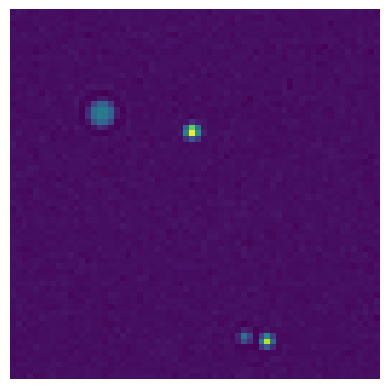

In [4]:
import deeptrack as dt
import numpy as np

def update_position(previous_value, diffusion_constant, dt=1/10):
    new_position = np.clip(previous_value + np.random.randn(2) 
                           * np.sqrt(diffusion_constant * dt) * 1e7, 0, image_size)
    return new_position

image_size = 64
sequence_length = 15

particle = dt.MieSphere(
    diffusion_constant=(1 + np.random.rand() * 9) * 1e-13,
    refractive_index=1.55,
    radius=lambda: np.random.uniform(1e-6/2, 1e-6*2),
    z=lambda: np.random.uniform(-2, 2) * dt.units.um,
    position=lambda: np.random.uniform(5, image_size - 5, 2),
)

optics = dt.Brightfield(
    NA=0.4,
    magnification=5,
    resolution=3e-6,
    wavelength=0.6e-6,
    output_region=(0, 0, image_size, image_size),
)

# %%
particle = dt.Sequential(particle, position=update_position)
particles = particle ^ (lambda: np.random.randint(2, 6)) 
image_pipeline = optics(particles) >> dt.Gaussian(sigma=0.1)

image_pipeline = dt.Sequence(image_pipeline, sequence_length=sequence_length)

image_pipeline.update().plot()

# generate a dataset of 1000 images
images = []
for i in range(1000):
    if i % 100 == 0:
        print(i)
    images.append(image_pipeline.update()())

In [3]:
# convert to tensor
tensors = torch.tensor(np.array([i for i in images])).float() - 1
#tensors = tensors.repeat(1, 3, 1, 1, 1)
print(tensors.shape)
# make channel first
tensors = tensors.permute(0, 1, 4, 2, 3)
train_set, test_set = torch.utils.data.random_split(tensors, [800, 200])

# create dataloaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=8, shuffle=False)

NameError: name 'images' is not defined

In [7]:
import matplotlib.pyplot as plt

def plot(model, test_loader):
    # forwards pass
    x = next(iter(test_loader))
    x = x[1:2]
    x = x.to(model.device)
    x_hat, indices, kl_divergence, xy, mu, logvar = model(x)

    flatind = indices[0, :].detach().cpu().numpy()
    xy = xy[0, :, indices].detach().cpu().numpy()
    row, col = np.unravel_index(flatind, (16, 16))
    row = (row + .5) * 4 - xy[0, :] * 2
    col = (col + .5) * 4 - xy[1, :] * 2
    kdiv = kl_divergence.view(1, 16, 16).detach().cpu().numpy()[0]
    

    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(x[0, 0, :, :].detach().cpu().numpy(), cmap="gray")
    plt.colorbar()
    plt.imshow(kdiv, extent=[0, 64, 64, 0], alpha=0.5, cmap="Blues")
    plt.scatter(col, row, c="blue", s=10)

    plt.subplot(1, 2, 2)
    plt.imshow(
        x_hat[0, 0, :, :].detach().cpu().numpy(),
        vmin=x[0, 0, :, :].min(),
        vmax=x[0, 0, :, :].max(),
        cmap="gray",
    )
    plt.colorbar()
    return plt

def plot(model, test_loader):
    # forwards pass
    x = next(iter(test_loader))
    x = x[1:2]
    x = x.to(model.device)
    x_hat, indices, kl_divergence, xy, mu, logvar, attention = model(x)

    x = x.detach().cpu().numpy()

    plt.figure(figsize=(15, 6))

    plt.subplot(2, 4, 4)
    plt.imshow(attention[0, :, :].detach().cpu().numpy(),)
    plt.xticks(np.arange(-.5, attention.shape[1], 1), minor=True)
    plt.yticks(np.arange(-.5, attention.shape[2], 1), minor=True)
    plt.grid(which='minor', color='w', linestyle='-', linewidth=0.5)
    plt.tick_params(which='minor', bottom=False, left=False)
    plt.colorbar()

    n = [0, 1, 2, 3, 4, 5]

    for i in range(mu.shape[0]):

        xy_mu = mu[i, :2].view(2, -1).detach().cpu().numpy()
        xy_logvar = logvar[i, :2].view(2, -1).detach().cpu().numpy()

        flatind = indices[i, :].detach().cpu().numpy()

        xy = xy_mu[:, flatind]
        xy_std = np.exp(xy_logvar[:, flatind] / 2)
        print(xy.shape)
        
        pos_gauss_map = np.zeros_like(x[0, 0])

        row, col = np.unravel_index(flatind, (16, 16))
        xp = (row + .5) * 4 - xy[0, :] * 2
        yp = (col + .5) * 4 - xy[1, :] * 2

        

        def gaussian_2d(x, y, x_std, y_std, x_size, y_size):
            xr = np.arange(x_size)
            yr = np.arange(y_size)
            X, Y = np.meshgrid(xr, yr)
            
            g =  np.exp(-((X - x) ** 2 / (2 * x_std ** 2) + (Y - y) ** 2 / (2 * y_std ** 2)))
            g *= 1 / (2 * np.pi * x_std * y_std)
            return g

        for j in range(xy.shape[1]):

            pos_gauss_map += gaussian_2d(
                yp[j], xp[j], xy_std[1, j] * 2, xy_std[0, j] * 2, 64, 64
            )

        #kdiv = kl_divergence[0, :].view(1, 16, 16).detach().cpu().numpy()[0]
        # print(pos_gauss_map)

        plt.subplot(2, 4, i+1)
        plt.imshow(x[0, i, 0, :, :], cmap="gray")
        plt.colorbar()
        #plt.imshow(kdiv, alpha=0.5, cmap="Blues", extent=[0, 64, 64, 0])
        alpha = np.sqrt(1 / np.square(xy_std).sum(0))
        alpha /= alpha.max()
        plt.scatter(yp, xp, marker="o", s=300, edgecolor="r", facecolor="none")
        for j, txt in enumerate(n):
            plt.annotate(txt, (yp[j], xp[j]), color='white')

        plt.subplot(2, 4, i+5)
        plt.imshow(
            x_hat[0, i, 0, :, :].detach().cpu().numpy(),
            vmin=x[0, i, 0, :, :].min(),
            vmax=x[0, i, 0, :, :].max(),
            cmap="gray",
        )
        plt.colorbar()


    return plt

## Create and run model

In [106]:
num_entities=10
model = MEVAE(num_entities=num_entities, beta=0, number_of_heads=1)
print(torch.cuda.device_count())


1


In [10]:
# anneal beta from 1e-10 to 1e-8 over 150 epochs
import numpy as np
import IPython.display as ipd

def beta_annealing(epoch):
    # if epoch >= 150:
    #     return 1e-8
    # else:
    logs = np.logspace(-8.3, -7, 300)
    return logs[int(epoch)]
    return 1e-8

class BetaCallback(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        pl_module.model.beta = beta_annealing(trainer.current_epoch)

class PlotCallback(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        ipd.clear_output(wait=True)
        plt.suptitle(f"Epoch {trainer.current_epoch}")
        plt.show()
        

#trainer = pl.Trainer(max_epochs=100, callbacks=[BetaCallback(), PlotCallback()])
#trainer.fit(model, train_loader)
#plot(model, test_loader)

In [1]:
def square_distance(x1, x2, y1, y2):
    dist = np.sqrt(np.square(x1 - x2) + np.square(y1-y2))
    return dist

test_num= 2
remove_and_combine = 1
combine_radius = 4

itera = iter(test_loader)
for i in range(test_num):
    x = next(itera)
x = x[1:2]
x = x.to(model.device)
x_hat, indices, kl_divergence, xy, mu, logvar, attention = model(x)

x = x.detach().cpu().numpy()

plt.figure(figsize=(15, 10))


n = [i for i in range(num_entities)]

combine_map_v = []
remove_map_v = []
xp_v = []
yp_v = []
for i in range(mu.shape[0]):

    xy_mu = mu[i, :2].view(2, -1).detach().cpu().numpy()
    xy_logvar = logvar[i, :2].view(2, -1).detach().cpu().numpy()

    flatind = indices[i, :].detach().cpu().numpy()

    mu_obj = mu[i, :].view(mu.shape[1], -1)[:, flatind]
    logvar_obj = mu[i, :].view(mu.shape[1], -1)[:, flatind]

    xy = xy_mu[:, flatind]
    xy_std = np.exp(xy_logvar[:, flatind] / 2)
    
    pos_gauss_map = np.zeros_like(x[0, 0])

    row, col = np.unravel_index(flatind, (16, 16))
    xp = (row + .5) * 4 - xy[0, :] * 2
    yp = (col + .5) * 4 - xy[1, :] * 2

    xp_v.append(xp)
    yp_v.append(yp)

    distances = []
    for j in range(xp.shape[0]):
        distance_r = []
        for k in range(xp.shape[0]):
            if j == k:
                distance_r.append(0)
                continue
            dist = square_distance(xp[j], xp[k], yp[j], yp[k])
            distance_r.append(dist)
        distances.append(distance_r)
    distances = np.array(distances)

    # Create the combin map
    row_indices, col_indices = np.indices(distances.shape)
    matrix = np.zeros(distances.shape)
    matrix[row_indices - col_indices <= 0] = 1

    if remove_and_combine:
        combine_map = (np.where(np.array(distances) < combine_radius, 1, 0).astype(np.bool) &  matrix.astype(np.bool)).astype(np.int32)
    else:
        combine_map = np.eye(combine_map.shape[0])
    
    remove_map = np.sum(combine_map - np.eye(combine_map.shape[0]), axis=0)

    combine_map_v.append(combine_map)
    remove_map_v.append(remove_map)

for i in range(mu.shape[0]):
    xp = xp_v[i]
    yp = yp_v[i]

    def gaussian_2d(x, y, x_std, y_std, x_size, y_size):
        xr = np.arange(x_size)
        yr = np.arange(y_size)
        X, Y = np.meshgrid(xr, yr)
        
        g =  np.exp(-((X - x) ** 2 / (2 * x_std ** 2) + (Y - y) ** 2 / (2 * y_std ** 2)))
        g *= 1 / (2 * np.pi * x_std * y_std)
        return g

    for j in range(xy.shape[1]):

        pos_gauss_map += gaussian_2d(
            yp[j], xp[j], xy_std[1, j] * 2, xy_std[0, j] * 2, 64, 64
        )

    #kdiv = kl_divergence[0, :].view(1, 16, 16).detach().cpu().numpy()[0]
    # print(pos_gauss_map)


    plt.subplot(4, 3, i+1)
    plt.imshow(x[0, i, 0, :, :], cmap="gray")
    plt.colorbar()
    #plt.imshow(kdiv, alpha=0.5, cmap="Blues", extent=[0, 64, 64, 0])
    alpha = np.sqrt(1 / np.square(xy_std).sum(0))
    alpha /= alpha.max()
    print(remove_map_v[i])
    plt.scatter(yp[~remove_map_v[i].astype(np.bool)], xp[~remove_map_v[i].astype(np.bool)], marker="o", s=300, edgecolor="r", facecolor="none")
    for j, txt in enumerate(n):
        if remove_map_v[i][j]:
            continue
        plt.annotate(txt, (yp[j], xp[j]), color='white')

    plt.subplot(4, 3, i+4)
    plt.imshow(
        x_hat[0, i, 0, :, :].detach().cpu().numpy(),
        vmin=x[0, i, 0, :, :].min(),
        vmax=x[0, i, 0, :, :].max(),
        cmap="gray",
    )
    plt.colorbar()

    if i == mu.shape[0]-1:
        break

    attention_to_next = attention[0, i*num_entities:(i+1)*num_entities, (i+1)*num_entities:(i+2)*num_entities]

    new_attention = []
    for j, row in enumerate(combine_map_v[i]):
        attention_to_next_dt = attention_to_next.detach().cpu().numpy()
        new_attention_row = np.transpose(np.transpose(attention_to_next_dt) * row)
        new_attention_row = np.sum(new_attention_row, axis = 0)/np.sum(row)
        if remove_map_v[i][j]:
            new_attention_row *= 0
        new_attention.append(new_attention_row)
    new_attention = np.array(new_attention)

    updated_attention = new_attention

    new_attention = []
    for j, row in enumerate(combine_map_v[i+1]):
        attention_to_next_dt = updated_attention
        new_attention_row = attention_to_next_dt * row
        new_attention_row = np.sum(new_attention_row, axis = 1)/np.sum(row)
        if remove_map_v[i+1][j]:
            new_attention_row *= 0
        new_attention.append(new_attention_row)
    new_attention = np.array(np.transpose(new_attention))

    plt.subplot(4, 3, i+7)
    plt.imshow(new_attention)
    plt.xticks(np.arange(-.5, attention_to_next.shape[1], 1), minor=True)
    plt.yticks(np.arange(-.5, attention_to_next.shape[1], 1), minor=True)
    plt.grid(which='minor', color='w', linestyle='-', linewidth=0.5)
    plt.tick_params(which='minor', bottom=False, left=False)

    plt.xticks(np.arange(-.5, attention_to_next.shape[1], num_entities), minor=False)
    plt.yticks(np.arange(-.5, attention_to_next.shape[1], num_entities), minor=False)
    plt.grid(which='major', color='w', linestyle='-', linewidth=2)
    plt.tick_params(which='major', bottom=False, left=False)
    plt.colorbar()


    #max_indices = torch.argmax(attention_to_next, axis=1)

    #binary_attention = torch.zeros_like(attention_to_next)
    #binary_attention[torch.arange(attention_to_next.size(0)), max_indices] = 1
    max_indices = np.argmax(new_attention, axis=1)
    binary_attention = np.zeros_like(new_attention)
    binary_attention[np.arange(new_attention.shape[0]), max_indices] = 1
    binary_attention *= np.where(new_attention > 0, 1, 0)

    plt.subplot(4, 3, i+10)
    plt.imshow(binary_attention)
    plt.xticks(np.arange(-.5, attention_to_next.shape[1], 1), minor=True)
    plt.yticks(np.arange(-.5, attention_to_next.shape[1], 1), minor=True)
    plt.grid(which='minor', color='w', linestyle='-', linewidth=0.5)
    plt.tick_params(which='minor', bottom=False, left=False)

    plt.xticks(np.arange(-.5, attention_to_next.shape[1], num_entities), minor=False)
    plt.yticks(np.arange(-.5, attention_to_next.shape[1], num_entities), minor=False)
    plt.grid(which='major', color='w', linestyle='-', linewidth=2)
    plt.tick_params(which='major', bottom=False, left=False)
    plt.colorbar()

NameError: name 'test_loader' is not defined

In [ ]:
torch.save(model.state_dict(), "../state_dicts/10-without_distbeta-1head-softmax.pth")

## Testing

### Helper functions

In [4]:
def beta_annealing(epoch):
    # if epoch >= 150:
    #     return 1e-8
    # else:
    logs = np.logspace(-8.3, -7, 300)
    return logs[int(epoch)]
    return 1e-8

class BetaCallback(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        pl_module.model.beta = beta_annealing(trainer.current_epoch)

class PlotCallback(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        ipd.clear_output(wait=True)
        plt.suptitle(f"Epoch {trainer.current_epoch}")
        plt.show()

def combine_nodes(attention_to_next, combine_map_v, remove_map_v, i_combine):
    new_attention = []
    for j, row in enumerate(combine_map_v[i_combine]):
        attention_to_next_dt = attention_to_next.detach().cpu().numpy()
        new_attention_row = np.transpose(np.transpose(attention_to_next_dt) * row)
        new_attention_row = np.sum(new_attention_row, axis = 0)/np.sum(row)
        if remove_map_v[i_combine][j]:
            new_attention_row *= 0
        new_attention.append(new_attention_row)
    new_attention = np.array(new_attention)

    updated_attention = new_attention

    new_attention = []
    for j, row in enumerate(combine_map_v[i_combine+1]):
        attention_to_next_dt = updated_attention
        new_attention_row = attention_to_next_dt * row
        new_attention_row = np.sum(new_attention_row, axis = 1)/np.sum(row)
        if remove_map_v[i_combine+1][j]:
            new_attention_row *= 0
        new_attention.append(new_attention_row)
    new_attention = np.array(np.transpose(new_attention))
    return new_attention

def distance_matrix(matrix_a, matrix_b):
    expanded_a = np.expand_dims(matrix_a, 1)  # Shape: (n, 1, m)
    expanded_b = np.expand_dims(matrix_b, 0)  # Shape: (1, n, m)
    expanded_a = np.transpose(expanded_a, (2, 1, 0))
    square_difference = np.square(expanded_a - expanded_b)  # Element-wise squared difference
    distances = np.sum(square_difference, axis=2)
    distances = np.sqrt(distances)
    return distances

import matplotlib.pyplot as plt

def distance(x1, x2, y1, y2):
    dist = np.sqrt(np.square(x1 - x2) + np.square(y1-y2))
    return dist


def run_test(model, combine_radius, plot_num = 0, num_entities=10):

    mse_total = []
    false_detections_total = []
    missed_detections_total = []
    tp_total = []
    fp_total = []
    tn_total = []
    fn_total = []
    for i_seq, x in enumerate(test):

        gt_nodes = test_centroids[i_seq]

        #x = x[1:2]
        x = torch.unsqueeze(x, dim=0)
        x = x.to(model.device)
        x_hat, indices, kl_divergence, xy, mu, logvar, attention = model(x)

        x = x.detach().cpu().numpy()
        
        if i_seq == plot_num:
            plt.figure(figsize=(15, 10))


        n = [i for i in range(num_entities)]

        combine_map_v = []
        remove_map_v = []
        xp_v = []
        yp_v = []
        for i in range(mu.shape[0]):

            xy_mu = mu[i, :2].view(2, -1).detach().cpu().numpy()

            flatind = indices[i, :].detach().cpu().numpy()

            mu_obj = mu[i, :].view(mu.shape[1], -1)[:, flatind]
            
            xy = xy_mu[:, flatind]
            
            row, col = np.unravel_index(flatind, (16, 16))
            xp = (row + .5) * 4 - xy[0, :] * 2
            yp = (col + .5) * 4 - xy[1, :] * 2

            xp_v.append(xp)
            yp_v.append(yp)

            distances = []
            for j in range(xp.shape[0]):
                distance_r = []
                for k in range(xp.shape[0]):
                    if j == k:
                        distance_r.append(0)
                        continue
                    dist = distance(xp[j], xp[k], yp[j], yp[k])
                    distance_r.append(dist)
                distances.append(distance_r)
            distances = np.array(distances)

            # Create the combin map
            row_indices, col_indices = np.indices(distances.shape)
            matrix = np.zeros(distances.shape)
            matrix[row_indices - col_indices <= 0] = 1

            combine_map = (np.where(np.array(distances) < combine_radius, 1, 0).astype(np.bool) &  matrix.astype(np.bool)).astype(np.int32)

            remove_map = np.sum(combine_map - np.eye(combine_map.shape[0]), axis=0)

            combine_map_v.append(combine_map)
            remove_map_v.append(remove_map)

        for i in range(mu.shape[0]):
            xp = xp_v[i]
            yp = yp_v[i]
            gt_nodes_timestep = np.array(gt_nodes[i])

            if i_seq == plot_num:
                plt.subplot(4, 3, i+1)
                plt.imshow(x[0, i, 0, :, :], cmap="gray")
                plt.colorbar()
                plt.scatter(yp[~remove_map_v[i].astype(np.bool)], xp[~remove_map_v[i].astype(np.bool)], marker="o", s=300, edgecolor="r", facecolor="none")
                for j, txt in enumerate(n):
                    if remove_map_v[i][j]:
                        continue
                    plt.annotate(txt, (yp[j], xp[j]), color='white')
                #plt.scatter(gt_nodes_timestep[:,1]*image_size, gt_nodes_timestep[:,0]*image_size, color='g')

            # Calculate node metrics
            xp_filtred = xp + remove_map_v[i]*1000
            yp_filtred = yp + remove_map_v[i]*1000

            distances = distance_matrix(np.array([xp_filtred/image_size, yp_filtred/image_size]), gt_nodes_timestep)
            min_distance = np.argmin(distances, axis=0)
            min_distance_2 = np.argmin(distances, axis=1)

            
            tn = 0
            tps = []
            missed_detections = 0
            false_detections = 0
            true_detections = 0
            for i_dist, dist_1 in enumerate(min_distance):
                if i_dist == min_distance_2[dist_1]:
                    tps.append(i_dist)
                else:
                    missed_detections += 1

            for i_dist, dist_2 in enumerate(min_distance_2):
                if remove_map_v[i][i_dist]:
                    continue
                if i_dist == min_distance[dist_2]:
                    true_detections += 1

                else:
                    false_detections += 1

            se = np.min(distances, axis=0)[tps]
            mse = np.mean(se)

            # Calculate attention metrics
            if i == 0:
                last_mapping = min_distance
                continue

            attention_to_next = attention[0, (i-1)*num_entities:i*num_entities, i*num_entities:(i+1)*num_entities]
            new_attention = combine_nodes(attention_to_next, combine_map_v, remove_map_v, i-1)

            gt_attention = np.zeros_like(new_attention)
            gt_attention[last_mapping, min_distance] += 1

            max_indices = np.argmax(new_attention, axis=1)
            binary_attention = np.zeros_like(new_attention)
            binary_attention[np.arange(new_attention.shape[0]), max_indices] = 1
            binary_attention *= np.where(new_attention > 0, 1, 0)


            tp = np.sum(gt_attention.astype(np.bool) & binary_attention.astype(np.bool))
            fp = np.sum(binary_attention.astype(np.bool)) - tp
            tn = np.sum(~gt_attention.astype(np.bool) & ~binary_attention.astype(np.bool))
            fn = np.sum(~binary_attention.astype(np.bool)) - tn

            mse_total.append(mse)
            false_detections_total.append(false_detections/(false_detections+true_detections))
            missed_detections_total.append(missed_detections/(min_distance.shape[0]))

            tp_total.append(tp)
            fp_total.append(fp)
            tn_total.append(tn)
            fn_total.append(fn)

            last_mapping = min_distance

            if i_seq == plot_num:
                plt.subplot(4, 3, i+4)
                plt.imshow(gt_attention)
                plt.xticks(np.arange(-.5, attention_to_next.shape[1], 1), minor=True)
                plt.yticks(np.arange(-.5, attention_to_next.shape[1], 1), minor=True)
                plt.grid(which='minor', color='w', linestyle='-', linewidth=0.5)
                plt.tick_params(which='minor', bottom=False, left=False)

                plt.xticks(np.arange(-.5, attention_to_next.shape[1], num_entities), minor=False)
                plt.yticks(np.arange(-.5, attention_to_next.shape[1], num_entities), minor=False)
                plt.grid(which='major', color='w', linestyle='-', linewidth=2)
                plt.tick_params(which='major', bottom=False, left=False)
                plt.colorbar()

                plt.subplot(4, 3, i+7)
                plt.imshow(binary_attention)
                plt.xticks(np.arange(-.5, attention_to_next.shape[1], 1), minor=True)
                plt.yticks(np.arange(-.5, attention_to_next.shape[1], 1), minor=True)
                plt.grid(which='minor', color='w', linestyle='-', linewidth=0.5)
                plt.tick_params(which='minor', bottom=False, left=False)

                plt.xticks(np.arange(-.5, attention_to_next.shape[1], num_entities), minor=False)
                plt.yticks(np.arange(-.5, attention_to_next.shape[1], num_entities), minor=False)
                plt.grid(which='major', color='w', linestyle='-', linewidth=2)
                plt.tick_params(which='major', bottom=False, left=False)
                plt.colorbar()

    mae_mean = np.mean(np.array(mse_total))
    fd_mean = np.mean(np.array(false_detections_total))
    md_mean = np.mean(np.array(missed_detections_total))

    tp_mean = np.mean(np.array(tp_total))
    fp_mean = np.mean(np.array(fp_total))
    tn_mean = np.mean(np.array(tn_total))
    fn_mean = np.mean(np.array(fn_total))

    precision = tp_mean/(tp_mean + fp_mean)
    recall = tp_mean/(tp_mean + fn_mean)

    f1 = 2*precision*recall/(precision+recall)

    return {
        "mae_mean": mae_mean,
        "fd_mean": fd_mean,
        "md_mean": md_mean,
        "precision": precision,
        "recall": recall,
        "f1-score": f1
        }



### Simulate a test set

2023-09-01 13:57:38.764229: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-01 13:57:40.541839: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstr

torch.Size([100, 15, 1, 64, 64])


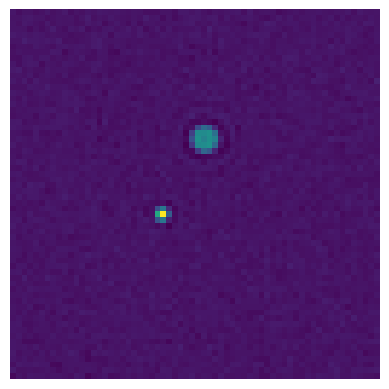

In [5]:
import deeptrack as dt
import numpy as np

def update_position(previous_value, diffusion_constant, dt=1/10):
    new_position = np.clip(previous_value + np.random.randn(2) * np.sqrt(diffusion_constant * dt) * 1e7, 0, image_size)
    return new_position

def get_positions(image):
    # All properties are stored in the `properties` field of the output.
    positions = image.get_property("position", get_one=False)
    return np.array(positions)/image_size

image_size = 64
sequence_length = 15

particle = dt.MieSphere(
    diffusion_constant=(1 + np.random.rand() * 9) * 1e-13,
    refractive_index=1.55,
    radius=lambda: np.random.uniform(1e-6/2, 1e-6*2),
    z=lambda: np.random.uniform(-2, 2) * dt.units.um,
    position=lambda: np.random.uniform(5, image_size - 5, 2),
)

optics = dt.Brightfield(
    NA=0.4,
    magnification=5,
    resolution=3e-6,
    wavelength=0.6e-6,
    output_region=(0, 0, image_size, image_size),
)

# %%
particle = dt.Sequential(particle, position=update_position)
particles = particle ^ (lambda: np.random.randint(2, 6)) 
image_pipeline = optics(particles) >> dt.Gaussian(sigma=0.1)

image_pipeline = dt.Sequence(image_pipeline, sequence_length=sequence_length)

image_pipeline.update().plot()

# generate a dataset of 1000 images
test_images = []
test_centroids = []
test_edges = []
for i in range(100):
    images = image_pipeline.update()()
    test_images.append(images)
    edges_image = []
    nodes = []
    for i, image in enumerate(images):
        positions = get_positions(image)
        nodes.append(positions)
        
        if i == len(images):
            break
        
        edges = []
        for j, _ in enumerate(positions):
            edges.append([j, j])
        edges_image.append(edges)
        
    test_centroids.append(nodes)
    test_edges.append(np.array(edges_image))


# convert to tensor
tensors = torch.tensor(np.array([i for i in test_images])).float() - 1
#tensors = tensors.repeat(1, 3, 1, 1, 1)

# make channel first
test = tensors.permute(0, 1, 4, 2, 3)
print(test.shape)

### Run test

#### Combine radius test

In [ ]:
num_entities=10
model = MEVAE(num_entities=num_entities, beta=0, number_of_heads=1)
print(torch.cuda.device_count())
model.load_state_dict(torch.load("../state_dicts/10-without_distbeta.pth"))

combine_radii = [0.1, 1, 2, 3, 4, 5, 6, 7, 8]
metrics_list = []

for radius in combine_radii:
    metrics = run_test(radius)
    metrics_list.append(metrics)
    print(metrics)

In [ ]:
import pandas as pd

df = pd.DataFrame(metrics_list)

plt.figure(figsize=(21, 5))

plt.subplot(1, 3, 1)

plt.title("F1-score")

plt.plot(combine_radii, df["f1-score"]*100, c="green", linewidth=2)
plt.fill_between(combine_radii, df["f1-score"]*100, 0, color='green', alpha=.1)
plt.legend(["f1-score (edges)"])
plt.ylabel("% of total")
plt.xlabel("Combine radius")
plt.ylim([0,100])
plt.grid()

plt.subplot(1, 3, 2)
plt.title("Missed and false detections")

plt.plot(combine_radii, df["md_mean"]*100, c="purple", linewidth=2)
plt.plot(combine_radii, df["fd_mean"]*100, c="orange", linewidth=2)
plt.fill_between(combine_radii, df["md_mean"]*100, 0, color='purple', alpha=.1)
plt.fill_between(combine_radii, df["fd_mean"]*100, 0, color='orange', alpha=.1)
plt.legend(['Missed detections (nodes)', "False detections (nodes)"])
plt.ylabel("% of total")
plt.xlabel("Combine radius")
plt.ylim([0,100])
plt.grid()


plt.subplot(1, 3, 3)
plt.plot(combine_radii, df["mae_mean"], c="red",linewidth=2)
plt.fill_between(combine_radii, df["mae_mean"], 0, color='red', alpha=.1)
plt.legend(['Mean abs error'])
plt.ylabel("Mean absolute error")
plt.xlabel("Combine radius")
plt.ylim([0,0.005])
plt.grid()

plt.title("Mean abs error (normalized point distance)")



df.head(10)

#### Num_entities test

<Figure size 640x480 with 0 Axes>

Epoch 99: 100%|██████████| 100/100 [00:16<00:00,  6.01it/s, v_num=725, loss_step=0.025, reconstruction_loss_step=0.0247, KLD_step=1.53e+3, weighted_KLD_step=0.000328, loss_epoch=0.0222, reconstruction_loss_epoch=0.0219, KLD_epoch=1.4e+3, weighted_KLD_epoch=0.000299] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 100/100 [00:16<00:00,  6.00it/s, v_num=725, loss_step=0.025, reconstruction_loss_step=0.0247, KLD_step=1.53e+3, weighted_KLD_step=0.000328, loss_epoch=0.0222, reconstruction_loss_epoch=0.0219, KLD_epoch=1.4e+3, weighted_KLD_epoch=0.000299]
{'mae_mean': 0.014438341428115975, 'fd_mean': 0.31898980064053595, 'md_mean': 0.0235, 'precision': 0.24287974683544303, 'recall': 0.4595808383233533, 'f1-score': 0.31780538302277433}


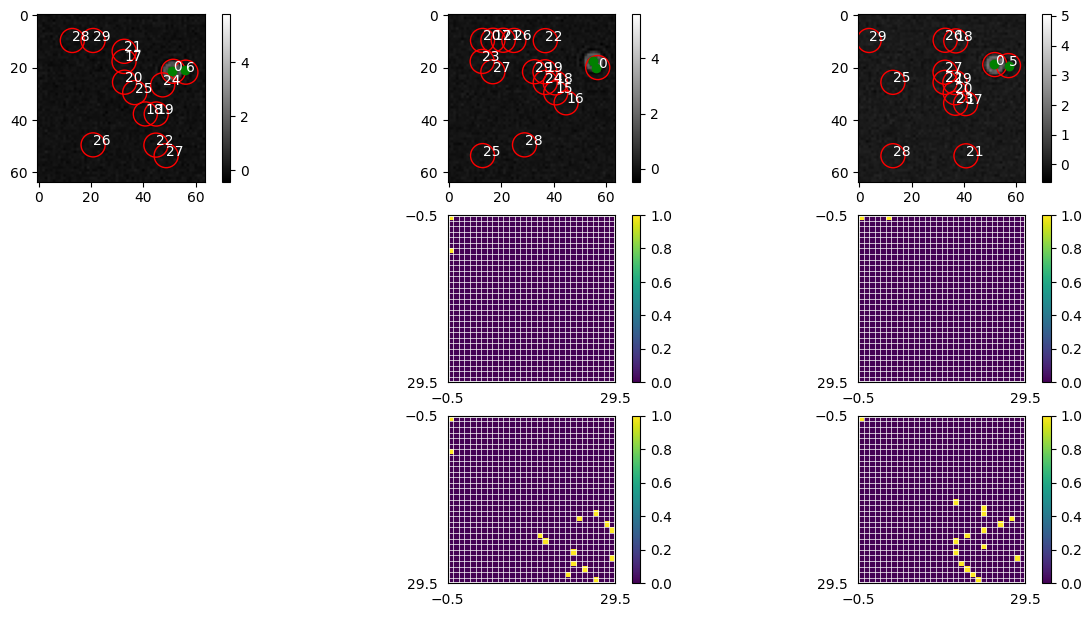

In [32]:
import numpy as np
import IPython.display as ipd


#num_entities_v = [1, 2, 4, 6, 8, 10]
num_entities_v = [25, 30]

#metrics_list = []
for num_entities in num_entities_v:

    model = MEVAE(num_entities=num_entities, beta=0, number_of_heads=1)
    trainer = pl.Trainer(max_epochs=100, callbacks=[BetaCallback(), PlotCallback()])
    trainer.fit(model, train_loader)

    metrics = run_test(model, 3, num_entities=num_entities)
    metrics_list.append(metrics)
    print(metrics)

,mae_mean,fd_mean,md_mean,precision,recall,f1-score
0,0.219139,0.000000,0.669833,1.000000,1.000000,1.000000
1,0.214061,0.305000,0.618667,0.542135,0.592025,0.565982
2,0.397907,0.631250,0.548750,0.146530,0.260274,0.187500
3,0.049690,0.292333,0.428333,0.464164,0.579957,0.515640
4,0.004891,0.093696,0.187333,0.638333,0.663778,0.650807
5,0.004747,0.086782,0.164167,0.674194,0.703704,0.688633
6,0.004409,0.121290,0.122917,0.590000,0.672638,0.628615
7,0.018840,0.392645,0.185250,0.357290,0.564019,0.437461
8,0.032975,0.516383,0.244917,0.262427,0.598333,0.364837
9,0.029186,0.508878,0.173583,0.290706,0.621622,0.396150


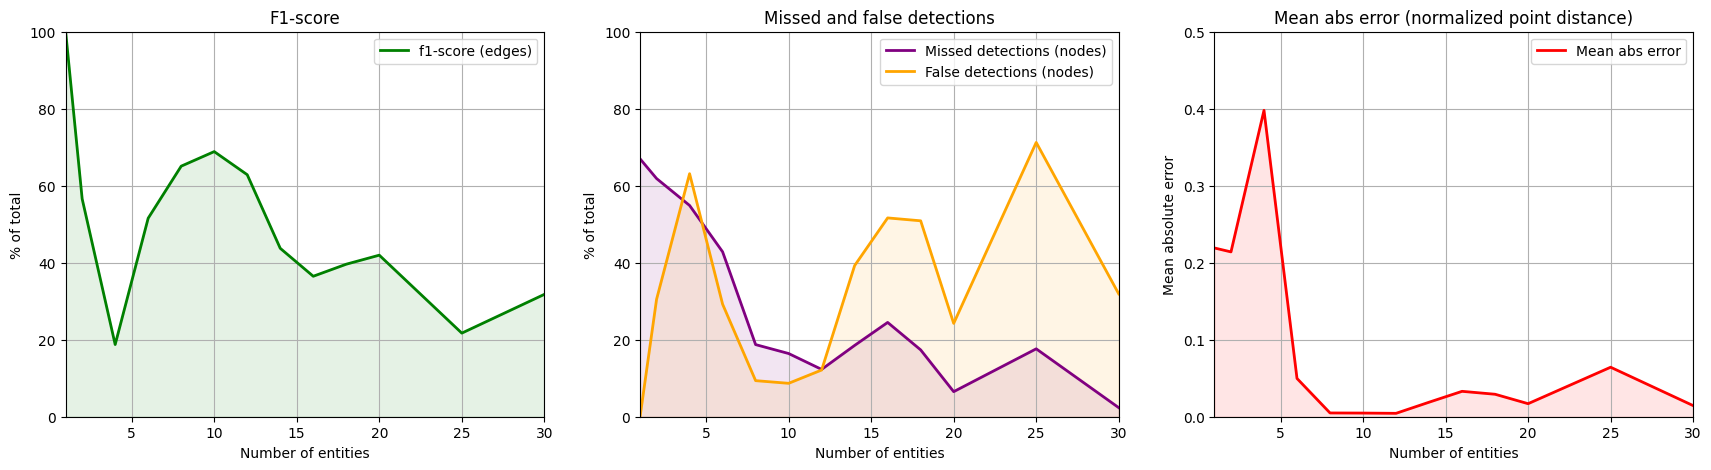

In [33]:
import pandas as pd

num_entities_v = [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 25, 30]
#num_entities_v  = num_heads


df = pd.DataFrame(metrics_list)

plt.figure(figsize=(21, 5))

plt.subplot(1, 3, 1)

plt.title("F1-score")

plt.plot(num_entities_v, df["f1-score"]*100, c="green", linewidth=2)
plt.fill_between(num_entities_v, df["f1-score"]*100, 0, color='green', alpha=.1)
plt.legend(["f1-score (edges)"])
plt.ylabel("% of total")
plt.xlabel("Number of entities")
plt.ylim([0,100])
plt.xlim([1,30])
plt.grid()

plt.subplot(1, 3, 2)
plt.title("Missed and false detections")

plt.plot(num_entities_v, df["md_mean"]*100, c="purple", linewidth=2)
plt.plot(num_entities_v, df["fd_mean"]*100, c="orange", linewidth=2)
plt.fill_between(num_entities_v, df["md_mean"]*100, 0, color='purple', alpha=.1)
plt.fill_between(num_entities_v, df["fd_mean"]*100, 0, color='orange', alpha=.1)
plt.legend(['Missed detections (nodes)', "False detections (nodes)"])
plt.ylabel("% of total")
plt.xlabel("Number of entities")
plt.ylim([0,100])
plt.xlim([1,30])
plt.grid()


plt.subplot(1, 3, 3)
plt.plot(num_entities_v, df["mae_mean"], c="red",linewidth=2)
plt.fill_between(num_entities_v, df["mae_mean"], 0, color='red', alpha=.1)
plt.legend(['Mean abs error'])
plt.ylabel("Mean absolute error")
plt.xlabel("Number of entities")
plt.ylim([0,0.5])
plt.xlim([1,30])
plt.grid()

plt.title("Mean abs error (normalized point distance)")



df.head(10)

#### Softmax temperature

<Figure size 640x480 with 0 Axes>

Epoch 99: 100%|██████████| 100/100 [00:06<00:00, 15.98it/s, v_num=844, loss_step=0.110, reconstruction_loss_step=0.110, KLD_step=1.13e+3, weighted_KLD_step=0.000243, loss_epoch=0.102, reconstruction_loss_epoch=0.102, KLD_epoch=1.13e+3, weighted_KLD_epoch=0.000242]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 100/100 [00:06<00:00, 15.95it/s, v_num=844, loss_step=0.110, reconstruction_loss_step=0.110, KLD_step=1.13e+3, weighted_KLD_step=0.000243, loss_epoch=0.102, reconstruction_loss_epoch=0.102, KLD_epoch=1.13e+3, weighted_KLD_epoch=0.000242]


/tmp/ipykernel_2657201/2558417935.py:124: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  combine_map = (np.where(np.array(distances) < combine_radius, 1, 0).astype(np.bool) &  matrix.astype(np.bool)).astype(np.int32)
/tmp/ipykernel_2657201/2558417935.py:140: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.scatter(yp[~remove_map_v[i].astype(np.bool

{'mae_mean': 0.03835784264172149, 'fd_mean': 0.4734861111111111, 'md_mean': 0.3295833333333333, 'precision': 0.32381889763779526, 'recall': 0.5812720848056537, 'f1-score': 0.415929203539823}


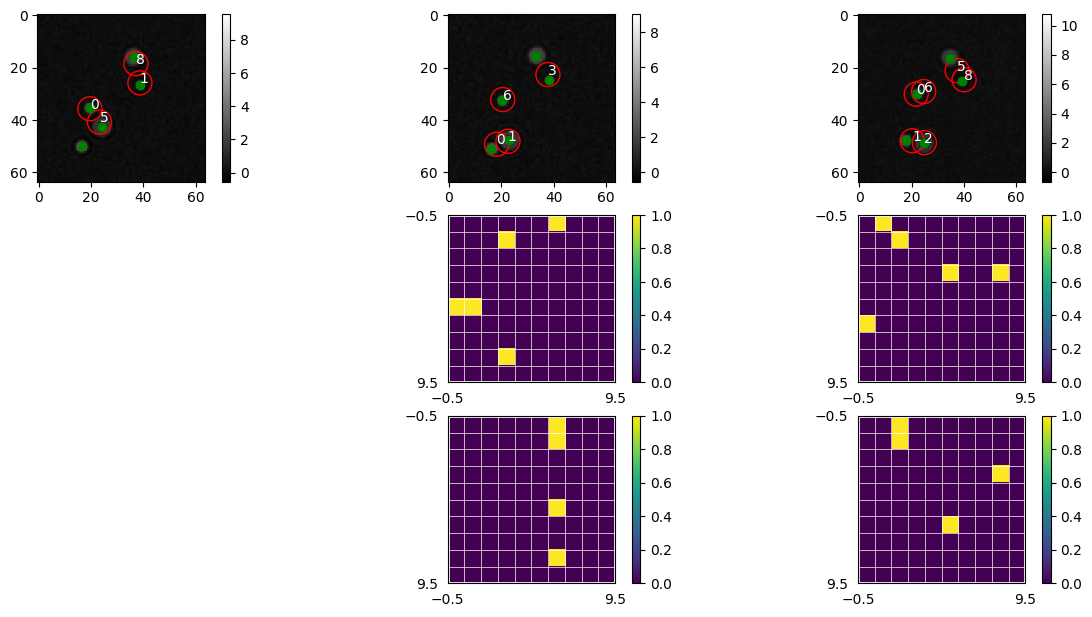

In [64]:
import numpy as np
import IPython.display as ipd


softmax_temperatures = [10,]

#metrics_list = []
for softmax_tmp in softmax_temperatures:

    model = MEVAE(num_entities=10, beta=0, number_of_heads=1, softmax_tmp=softmax_tmp)
    trainer = pl.Trainer(max_epochs=100, callbacks=[BetaCallback(), PlotCallback()])
    trainer.fit(model, train_loader)

    metrics = run_test(model, 3, num_entities=10)
    metrics_list.append(metrics)
    print(metrics)

/tmp/ipykernel_2657201/2558417935.py:124: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  combine_map = (np.where(np.array(distances) < combine_radius, 1, 0).astype(np.bool) &  matrix.astype(np.bool)).astype(np.int32)
/tmp/ipykernel_2657201/2558417935.py:140: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.scatter(yp[~remove_map_v[i].astype(np.bool

{'mae_mean': 0.03835784264172149, 'fd_mean': 0.4734861111111111, 'md_mean': 0.3295833333333333, 'precision': 0.3326771653543307, 'recall': 0.597173144876325, 'f1-score': 0.42730720606826794}


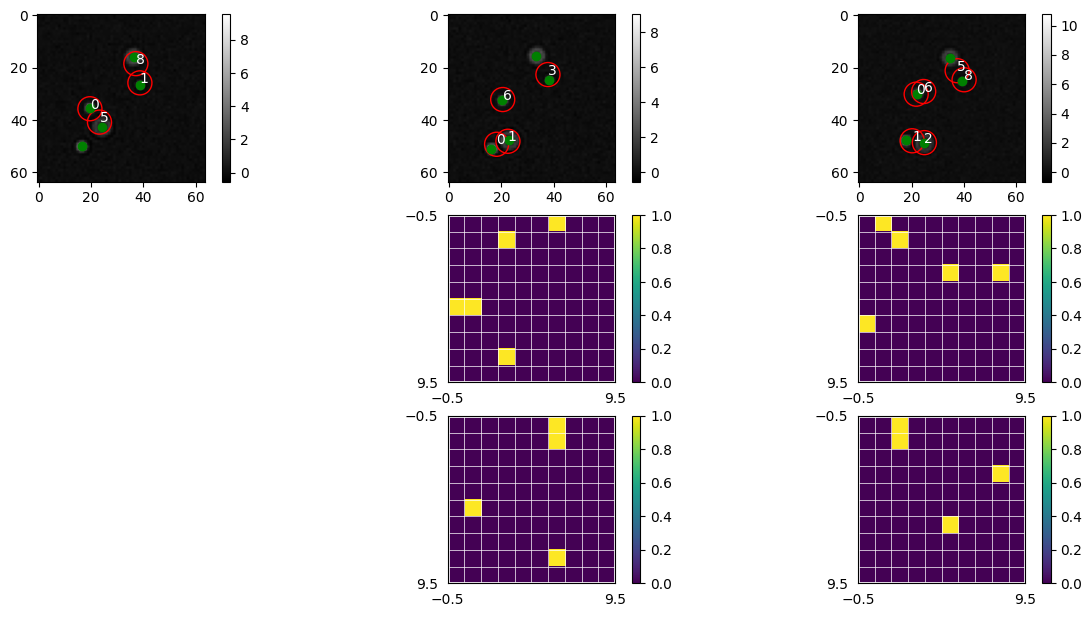

In [66]:
metrics = run_test(model, 3, num_entities=10)
metrics_list.append(metrics)
print(metrics)

,mae_mean,fd_mean,md_mean,precision,recall,f1-score
0,0.003320,0.057988,0.213417,0.715026,0.716263,0.715644
1,0.122980,0.740036,0.468583,0.136303,0.387524,0.201672
2,0.019566,0.342143,0.287167,0.452237,0.631757,0.527132
3,0.054167,0.594135,0.267333,0.261261,0.571429,0.358578
4,0.065553,0.634802,0.394250,0.194268,0.454376,0.272170
5,0.187085,0.828075,0.540583,0.086150,0.326446,0.136324


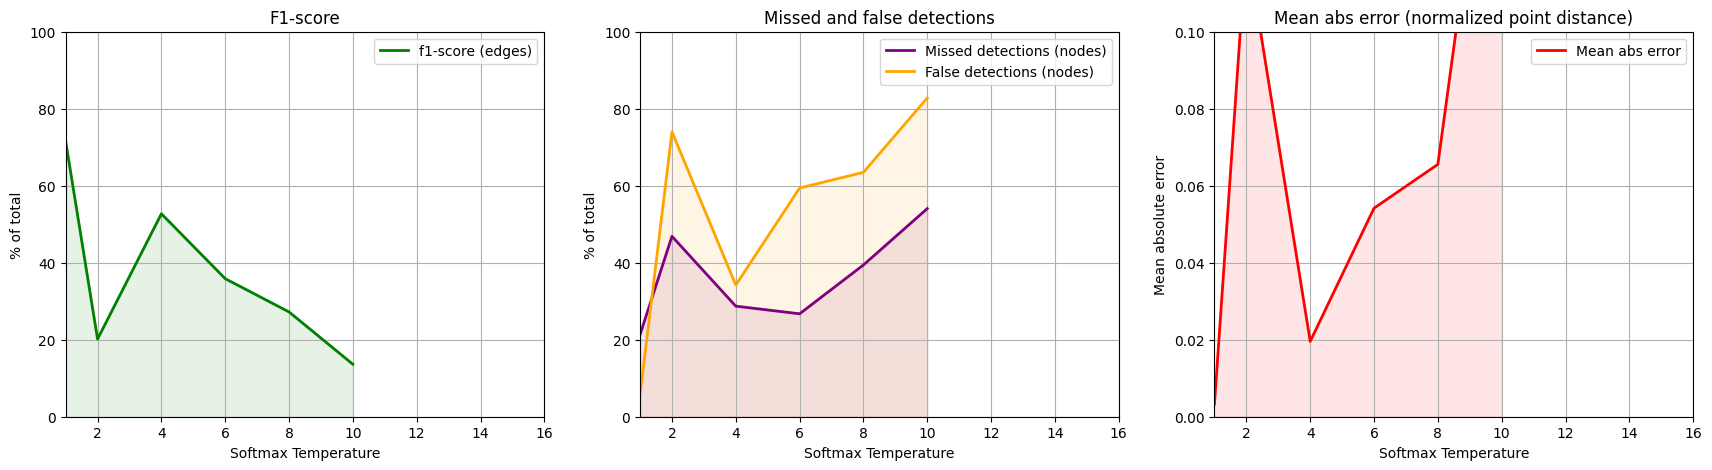

In [22]:
import pandas as pd

softmax_temperatures = [1, 2, 4, 6, 8, 10]

df = pd.DataFrame(new_list)

plt.figure(figsize=(21, 5))

plt.subplot(1, 3, 1)

plt.title("F1-score")

plt.plot(softmax_temperatures, df["f1-score"]*100, c="green", linewidth=2)
plt.fill_between(softmax_temperatures, df["f1-score"]*100, 0, color='green', alpha=.1)
plt.legend(["f1-score (edges)"])
plt.ylabel("% of total")
plt.xlabel("Softmax Temperature")
plt.ylim([0,100])
plt.xlim([1,16])
plt.grid()

plt.subplot(1, 3, 2)
plt.title("Missed and false detections")

plt.plot(softmax_temperatures, df["md_mean"]*100, c="purple", linewidth=2)
plt.plot(softmax_temperatures, df["fd_mean"]*100, c="orange", linewidth=2)
plt.fill_between(softmax_temperatures, df["md_mean"]*100, 0, color='purple', alpha=.1)
plt.fill_between(softmax_temperatures, df["fd_mean"]*100, 0, color='orange', alpha=.1)
plt.legend(['Missed detections (nodes)', "False detections (nodes)"])
plt.ylabel("% of total")
plt.xlabel("Softmax Temperature")
plt.ylim([0,100])
plt.xlim([1,16])
plt.grid()


plt.subplot(1, 3, 3)
plt.plot(softmax_temperatures, df["mae_mean"], c="red",linewidth=2)
plt.fill_between(softmax_temperatures, df["mae_mean"], 0, color='red', alpha=.1)
plt.legend(['Mean abs error'])
plt.ylabel("Mean absolute error")
plt.xlabel("Softmax Temperature")
plt.ylim([0,0.1])
plt.xlim([1,16])
plt.grid()

plt.title("Mean abs error (normalized point distance)")



df.head(15)

#### Number of heads

<Figure size 640x480 with 0 Axes>

Epoch 99: 100%|██████████| 100/100 [00:06<00:00, 16.19it/s, v_num=774, loss_step=0.184, reconstruction_loss_step=0.184, KLD_step=1.15e+3, weighted_KLD_step=0.000245, loss_epoch=0.183, reconstruction_loss_epoch=0.183, KLD_epoch=1.01e+3, weighted_KLD_epoch=0.000215]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 100/100 [00:06<00:00, 16.16it/s, v_num=774, loss_step=0.184, reconstruction_loss_step=0.184, KLD_step=1.15e+3, weighted_KLD_step=0.000245, loss_epoch=0.183, reconstruction_loss_epoch=0.183, KLD_epoch=1.01e+3, weighted_KLD_epoch=0.000215]
{'mae_mean': 0.2408779686107221, 'fd_mean': 0.8452500000000001, 'md_mean': 0.5463333333333333, 'precision': 0.03530031612223393, 'recall': 0.13214990138067062, 'f1-score': 0.05571725571725571}


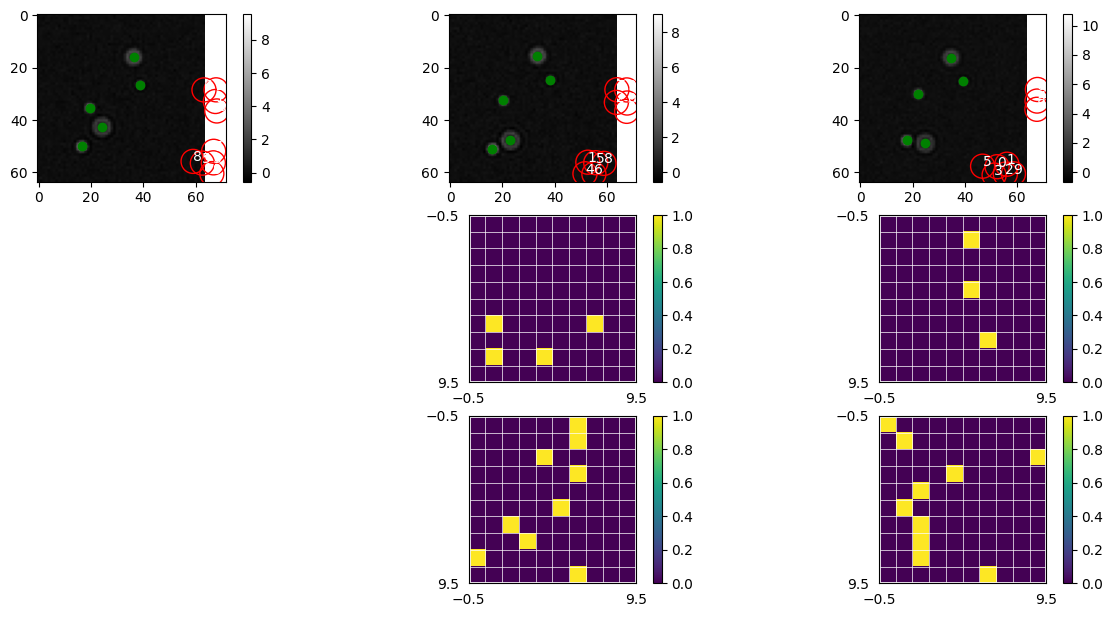

In [14]:
import numpy as np
import IPython.display as ipd


heads = [1, 2, 5]

metrics_list = []
for head in heads:

    model = MEVAE(num_entities=10, beta=0, number_of_heads=head, softmax_tmp=1)
    trainer = pl.Trainer(max_epochs=100, callbacks=[BetaCallback(), PlotCallback()])
    trainer.fit(model, train_loader)

    metrics = run_test(model, 3, num_entities=10)
    metrics_list.append(metrics)
    print(metrics)

In [99]:
print(len(metrics_list))

2


,mae_mean,fd_mean,md_mean,precision,recall,f1-score
0,0.005676,0.031667,0.177667,0.667241,0.651515,0.659284
1,0.216403,0.827413,0.545417,0.058994,0.204000,0.091521
2,0.240878,0.845250,0.546333,0.035300,0.132150,0.055717


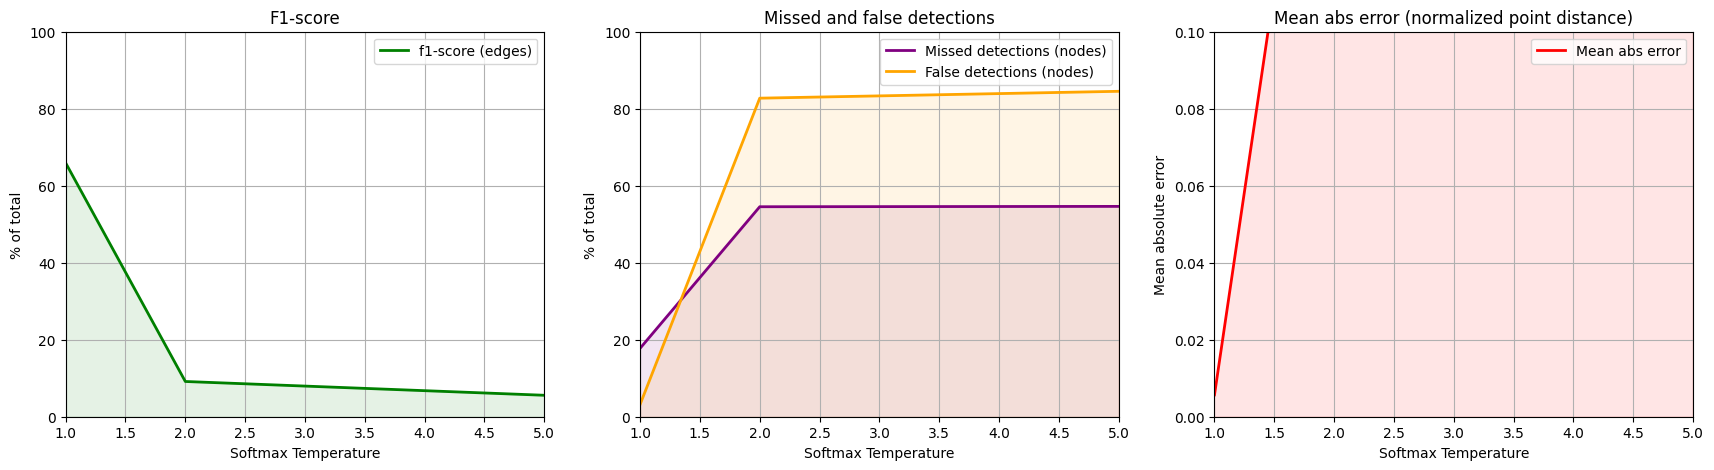

In [15]:
import pandas as pd

heads = [1, 2, 5]

df = pd.DataFrame(metrics_list)

plt.figure(figsize=(21, 5))

plt.subplot(1, 3, 1)

plt.title("F1-score")

plt.plot(heads, df["f1-score"]*100, c="green", linewidth=2)
plt.fill_between(heads, df["f1-score"]*100, 0, color='green', alpha=.1)
plt.legend(["f1-score (edges)"])
plt.ylabel("% of total")
plt.xlabel("Softmax Temperature")
plt.ylim([0,100])
plt.xlim([1,5])
plt.grid()

plt.subplot(1, 3, 2)
plt.title("Missed and false detections")

plt.plot(heads, df["md_mean"]*100, c="purple", linewidth=2)
plt.plot(heads, df["fd_mean"]*100, c="orange", linewidth=2)
plt.fill_between(heads, df["md_mean"]*100, 0, color='purple', alpha=.1)
plt.fill_between(heads, df["fd_mean"]*100, 0, color='orange', alpha=.1)
plt.legend(['Missed detections (nodes)', "False detections (nodes)"])
plt.ylabel("% of total")
plt.xlabel("Softmax Temperature")
plt.ylim([0,100])
plt.xlim([1,5])
plt.grid()


plt.subplot(1, 3, 3)
plt.plot(heads, df["mae_mean"], c="red",linewidth=2)
plt.fill_between(heads, df["mae_mean"], 0, color='red', alpha=.1)
plt.legend(['Mean abs error'])
plt.ylabel("Mean absolute error")
plt.xlabel("Softmax Temperature")
plt.ylim([0,0.1])
plt.xlim([1,5])
plt.grid()

plt.title("Mean abs error (normalized point distance)")



df.head(15)

#### Different vs not

In [19]:
import deeptrack as dt
import numpy as np

def update_position(previous_value, diffusion_constant, dt=1/10):
    new_position = np.clip(previous_value + np.random.randn(2) 
                           * np.sqrt(diffusion_constant * dt) * 1e7, 0, image_size)
    return new_position

def get_positions(image):
    # All properties are stored in the `properties` field of the output.
    positions = image.get_property("position", get_one=False)
    return np.array(positions)/image_size

def generate_data(difference):

    image_size = 64
    sequence_length = 3

    if difference:
        particle = dt.MieSphere(
            diffusion_constant=(1 + np.random.rand() * 9) * 1e-13,
            refractive_index=1.55,
            radius=lambda: np.random.uniform(1e-6/2, 1e-6*2),
            z=lambda: np.random.uniform(-2, 2) * dt.units.um,
            position=lambda: np.random.uniform(5, image_size - 5, 2),
        )
    else:
        particle = dt.MieSphere(
            diffusion_constant=(1 + np.random.rand() * 9) * 1e-13,
            refractive_index=1.55,
            radius=1e-6,
            z=lambda: np.random.uniform(-2, 2) * dt.units.um,
            position=lambda: np.random.uniform(5, image_size - 5, 2),
        )

    optics = dt.Brightfield(
        NA=0.4,
        magnification=5,
        resolution=3e-6,
        wavelength=0.6e-6,
        output_region=(0, 0, image_size, image_size),
    )

    # %%
    particle = dt.Sequential(particle, position=update_position)
    particles = particle ^ (lambda: np.random.randint(2, 6)) 
    image_pipeline = optics(particles) >> dt.Gaussian(sigma=0.1)

    image_pipeline = dt.Sequence(image_pipeline, sequence_length=sequence_length)

    image_pipeline.update().plot()

    # generate a dataset of 1000 images
    print("Generating Training data")
    images = []
    for i in range(1000):
        if i % 100 == 0:
            print(i)
        images.append(image_pipeline.update()())

    # convert to tensor
    tensors = torch.tensor(np.array([i for i in images])).float() - 1
    #tensors = tensors.repeat(1, 3, 1, 1, 1)
    print(tensors.shape)
    # make channel first
    tensors = tensors.permute(0, 1, 4, 2, 3)
    train_set, test_set = torch.utils.data.random_split(tensors, [800, 200])

    # create dataloaders
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=8, shuffle=False)
        
    
    print("Generating Test data")
    # generate a dataset of 1000 images
    test_images = []
    test_centroids = []
    test_edges = []
    for i in range(100):
        images = image_pipeline.update()()
        test_images.append(images)
        edges_image = []
        nodes = []
        for i, image in enumerate(images):
            positions = get_positions(image)
            nodes.append(positions)
            
            if i == len(images):
                break
            
            edges = []
            for j, _ in enumerate(positions):
                edges.append([j, j])
            edges_image.append(edges)
            
        test_centroids.append(nodes)
        test_edges.append(np.array(edges_image))


    # convert to tensor
    tensors = torch.tensor(np.array([i for i in test_images])).float() - 1
    #tensors = tensors.repeat(1, 3, 1, 1, 1)

    # make channel first
    test = tensors.permute(0, 1, 4, 2, 3)

    return train_loader, test_loader, test, test_centroids, test_edges
    print(test.shape)

<Figure size 640x480 with 0 Axes>

Epoch 9: 100%|██████████| 100/100 [00:06<00:00, 14.86it/s, v_num=541, loss_step=0.0654, reconstruction_loss_step=0.0653, KLD_step=722.0, weighted_KLD_step=6.27e-5, loss_epoch=0.0661, reconstruction_loss_epoch=0.066, KLD_epoch=716.0, weighted_KLD_epoch=6.22e-5] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 100/100 [00:06<00:00, 14.81it/s, v_num=541, loss_step=0.0654, reconstruction_loss_step=0.0653, KLD_step=722.0, weighted_KLD_step=6.27e-5, loss_epoch=0.0661, reconstruction_loss_epoch=0.066, KLD_epoch=716.0, weighted_KLD_epoch=6.22e-5]
{'mae_mean': 0.01000460752648749, 'fd_mean': 0.1321190476190476, 'md_mean': 0.28850000000000003, 'precision': 0.5758039816232772, 'recall': 0.6194398682042833, 'f1-score': 0.5968253968253968}


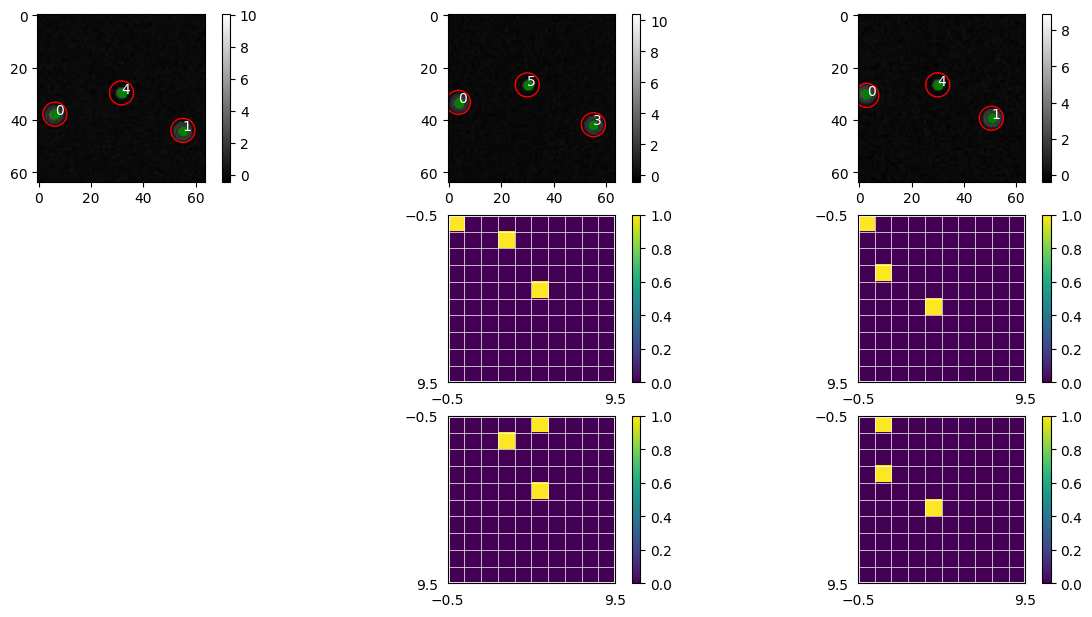

In [125]:
import numpy as np
import IPython.display as ipd

epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
metrics_list = []
model = MEVAE(num_entities=10, beta=0, number_of_heads=1)
train_loader, test_loader, test, test_centroids, test_edges = generate_data(difference=False)
for epoch in epochs:

    trainer = pl.Trainer(max_epochs=10, callbacks=[BetaCallback(), PlotCallback()])
    trainer.fit(model, train_loader)

    metrics = run_test(model, 4, num_entities=10)
    metrics_list.append(metrics)
    print(metrics)

train_loader, test_loader, test, test_centroids, test_edges = generate_data(difference=True)
metrics_list_difference = []
model = MEVAE(num_entities=10, beta=0, number_of_heads=1)
for epoch in epochs:

    trainer = pl.Trainer(max_epochs=10, callbacks=[BetaCallback(), PlotCallback()])
    trainer.fit(model, train_loader)

    metrics = run_test(model, 4, num_entities=10)
    metrics_list_difference.append(metrics)
    print(metrics)

,mae_mean,fd_mean,md_mean,precision,recall,f1-score
0,0.007781,0.095000,0.208333,0.452579,0.453333,0.452956
1,0.007165,0.086250,0.214000,0.467241,0.455462,0.461277
2,0.007899,0.106095,0.215000,0.440336,0.440336,0.440336
3,0.007697,0.142452,0.253333,0.428571,0.445596,0.436918
4,0.012414,0.206780,0.291083,0.420732,0.480000,0.448416
5,0.020900,0.301653,0.331667,0.373154,0.496429,0.426054
6,0.026852,0.350736,0.338000,0.346447,0.491007,0.406250
7,0.030932,0.409530,0.341083,0.314451,0.489209,0.382829
8,0.036018,0.435948,0.353917,0.293407,0.481081,0.364505
9,0.055024,0.554911,0.386667,0.210718,0.426471,0.282067


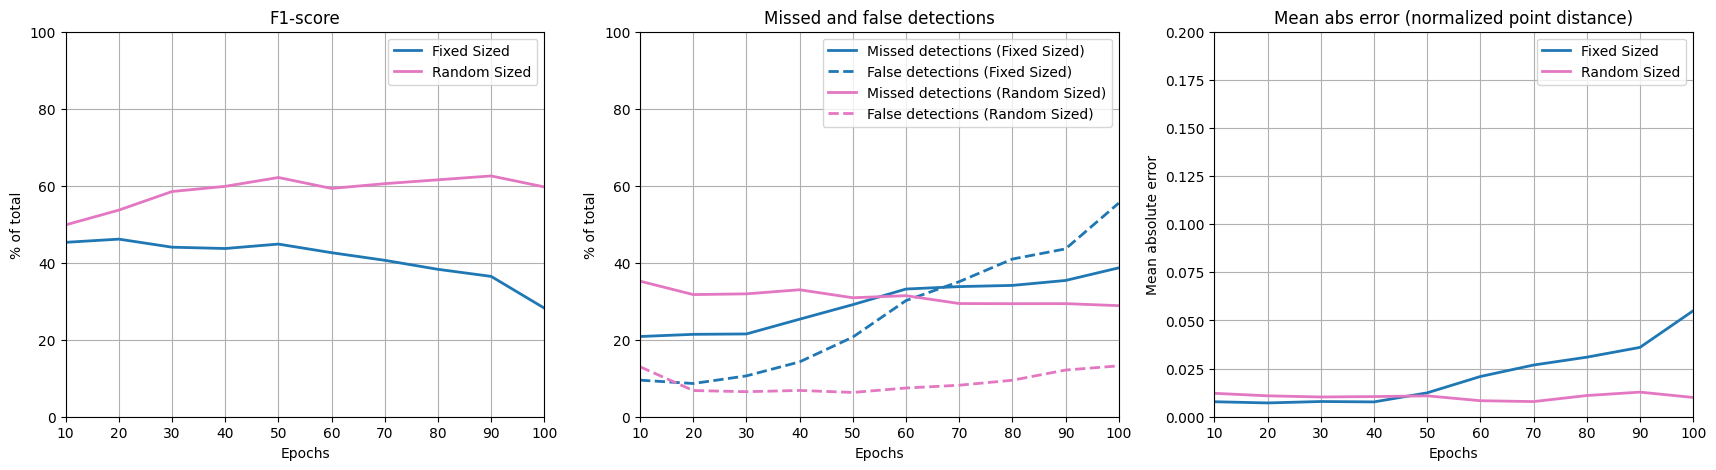

In [126]:
import pandas as pd

#num_entities_v = [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
#num_entities_v  = num_heads


df = pd.DataFrame(metrics_list)
df_diff = pd.DataFrame(metrics_list_difference)
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
epochs = np.array(epochs)*10

color_fixed = 'C0'
color_random = 'C6'

plt.figure(figsize=(21, 5))

plt.subplot(1, 3, 1)

plt.title("F1-score")

plt.plot(epochs, df["f1-score"]*100, linewidth=2, c=color_fixed)
plt.plot(epochs, df_diff["f1-score"]*100, linewidth=2, c=color_random)
#plt.fill_between(epochs, df["f1-score"]*100, 0, color='green', alpha=.1)
plt.legend(["Fixed Sized", "Random Sized"])
plt.ylabel("% of total")
plt.xlabel("Epochs")
plt.ylim([0,100])
plt.xlim([10,100])
plt.grid()

plt.subplot(1, 3, 2)
plt.title("Missed and false detections")

plt.plot(epochs, df["md_mean"]*100, linewidth=2, c=color_fixed)
plt.plot(epochs, df["fd_mean"]*100, linewidth=2, c=color_fixed, linestyle='--')
plt.plot(epochs, df_diff["md_mean"]*100, linewidth=2, c=color_random)
plt.plot(epochs, df_diff["fd_mean"]*100, linewidth=2, c=color_random, linestyle='--')
#plt.fill_between(epochs, df["md_mean"]*100, 0, color='purple', alpha=.1)
#plt.fill_between(epochs, df["fd_mean"]*100, 0, color='orange', alpha=.1)
plt.legend(['Missed detections (Fixed Sized)', "False detections (Fixed Sized)", 'Missed detections (Random Sized)', "False detections (Random Sized)"])
plt.ylabel("% of total")
plt.xlabel("Epochs")
plt.ylim([0,100])
plt.xlim([10,100])
plt.grid()


plt.subplot(1, 3, 3)
plt.plot(epochs, df["mae_mean"], linewidth=2, c=color_fixed)
plt.plot(epochs, df_diff["mae_mean"], linewidth=2, c=color_random)
#plt.fill_between(epochs, df["mae_mean"], 0, color='red', alpha=.1)
plt.legend(['Fixed Sized', "Random Sized"])
plt.ylabel("Mean absolute error")
plt.xlabel("Epochs")
plt.ylim([0,0.2])
plt.xlim([10,100])
plt.grid()

plt.title("Mean abs error (normalized point distance)")



df.head(10)

In [127]:
df_diff.head(10)

,mae_mean,fd_mean,md_mean,precision,recall,f1-score
0,0.012163,0.129667,0.352083,0.508772,0.488215,0.498282
1,0.010857,0.068000,0.317250,0.551418,0.522689,0.536670
2,0.010258,0.065000,0.319167,0.599641,0.570940,0.584939
3,0.010468,0.068250,0.329750,0.609800,0.587413,0.598397
4,0.010839,0.063083,0.309000,0.631119,0.611864,0.621343
5,0.008318,0.074595,0.314417,0.598604,0.587329,0.592913
6,0.007866,0.081821,0.294000,0.602329,0.608403,0.605351
7,0.011008,0.094714,0.293583,0.605475,0.625624,0.615385
8,0.012781,0.121220,0.293750,0.601236,0.651591,0.625402
9,0.010005,0.132119,0.288500,0.575804,0.619440,0.596825


#### Longer sequences

In [12]:
import deeptrack as dt
import numpy as np

image_size = 64

def update_position(previous_value, diffusion_constant, dt=1/10):
    new_position = np.clip(previous_value + np.random.randn(2) 
                           * np.sqrt(diffusion_constant * dt) * 1e7, 0, image_size)
    return new_position

def get_positions(image):
    # All properties are stored in the `properties` field of the output.
    positions = image.get_property("position", get_one=False)
    return np.array(positions)/image_size

def generate_data(sequence_length):

    image_size = 64

    particle = dt.MieSphere(
        diffusion_constant=(1 + np.random.rand() * 9) * 1e-13,
        refractive_index=1.55,
        radius=lambda: np.random.uniform(1e-6/2, 1e-6*2),
        z=lambda: np.random.uniform(-2, 2) * dt.units.um,
        position=lambda: np.random.uniform(5, image_size - 5, 2),
    )

    optics = dt.Brightfield(
        NA=0.4,
        magnification=5,
        resolution=3e-6,
        wavelength=0.6e-6,
        output_region=(0, 0, image_size, image_size),
    )

    # %%
    particle = dt.Sequential(particle, position=update_position)
    particles = particle ^ (lambda: np.random.randint(2, 6)) 
    image_pipeline = optics(particles) >> dt.Gaussian(sigma=0.1)

    image_pipeline = dt.Sequence(image_pipeline, sequence_length=sequence_length)

    image_pipeline.update().plot()

    # generate a dataset of 1000 images
    print("Generating Training data")
    images = []
    for i in range(1000):
        if i % 100 == 0:
            print(i)
        images.append(image_pipeline.update()())

    # convert to tensor
    tensors = torch.tensor(np.array([i for i in images])).float() - 1
    #tensors = tensors.repeat(1, 3, 1, 1, 1)
    print(tensors.shape)
    # make channel first
    tensors = tensors.permute(0, 1, 4, 2, 3)
    train_set, test_set = torch.utils.data.random_split(tensors, [800, 200])

    # create dataloaders
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=8, shuffle=False)
        
    
    print("Generating Test data")
    # generate a dataset of 1000 images
    test_images = []
    test_centroids = []
    test_edges = []
    for i in range(100):
        images = image_pipeline.update()()
        test_images.append(images)
        edges_image = []
        nodes = []
        for i, image in enumerate(images):
            positions = get_positions(image)
            nodes.append(positions)
            
            if i == len(images):
                break
            
            edges = []
            for j, _ in enumerate(positions):
                edges.append([j, j])
            edges_image.append(edges)
            
        test_centroids.append(nodes)
        test_edges.append(np.array(edges_image))


    # convert to tensor
    tensors = torch.tensor(np.array([i for i in test_images])).float() - 1
    #tensors = tensors.repeat(1, 3, 1, 1, 1)

    # make channel first
    test = tensors.permute(0, 1, 4, 2, 3)

    return train_loader, test_loader, test, test_centroids, test_edges
    print(test.shape)

/tmp/ipykernel_90445/2221305508.py:64: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  combine_map = (np.where(np.array(distances) < combine_radius, 1, 0).astype(np.bool) &  matrix.astype(np.bool)).astype(np.int32)
/tmp/ipykernel_90445/2221305508.py:141: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp = np.sum(gt_attention.astype(np.bool) & binary_a

0:1
2:3
3:1
0:0
1:2
3:2
0:0
2:4
{'mae_mean': 0.044738888048274486, 'fd_mean': 0.3129484126984127, 'md_mean': 0.22144444444444444, 'precision': 0.42573471008737085, 'recall': 0.5896589658965896, 'f1-score': 0.49446494464944646}


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

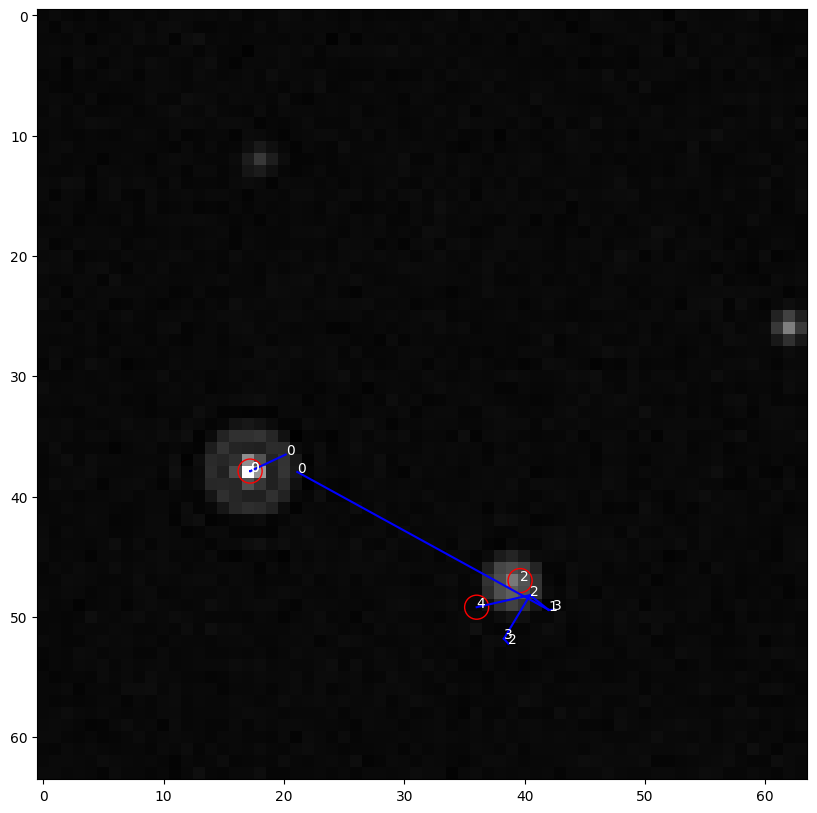

In [26]:
sequence_lengths = [5]

metrics_list = []
for sequence_length in sequence_lengths:
    #model = MEVAE(num_entities=10, beta=0, number_of_heads=1)
    #train_loader, test_loader, test, test_centroids, test_edges = generate_data(sequence_length=sequence_length)

    #trainer = pl.Trainer(max_epochs=100, callbacks=[BetaCallback()])
    #trainer.fit(model, train_loader)

    #metrics = run_test(model, 4, num_entities=10, plot_num=3)
    #metrics_list.append(metrics)
    #print(metrics)

In [17]:
import pandas as pd

df_1 = pd.read_csv("./tmp_csv.csv")

df_2 = pd.DataFrame(metrics_list)

df = pd.concat([df_1, df_2])

df.head()



,Unnamed: 0,mae_mean,fd_mean,md_mean,precision,recall,f1-score
0,0.0,0.090672,0.591833,0.431167,0.316719,0.636743,0.423024
1,1.0,0.005819,0.206702,0.247542,0.555136,0.651596,0.599511
2,2.0,0.033069,0.279249,0.303889,0.498905,0.684084,0.577001
3,3.0,0.002842,0.038179,0.048729,0.755352,0.775206,0.765150
4,4.0,0.027073,0.192479,0.278517,0.593067,0.727923,0.653612


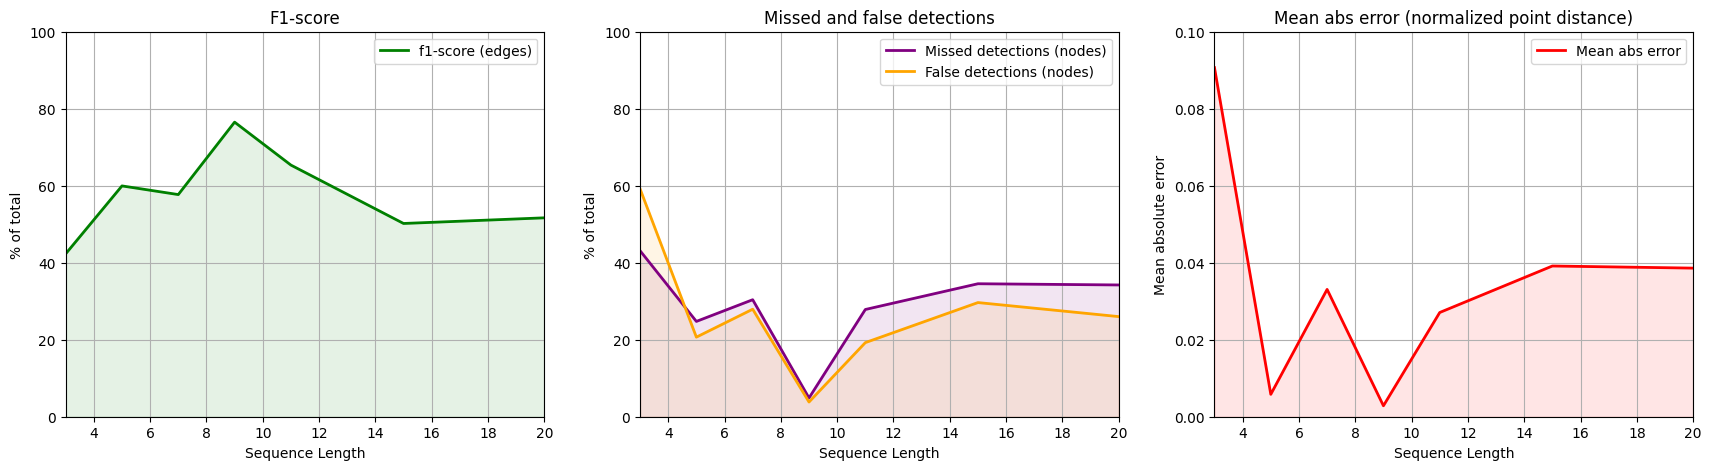

In [20]:
import pandas as pd
from matplotlib import pyplot as plt

    
#df = pd.DataFrame(metrics_list)

plt.figure(figsize=(21, 5))

sequence_lengths = [3, 5, 7, 9, 11, 15, 20]

plt.subplot(1, 3, 1)

plt.title("F1-score")

plt.plot(sequence_lengths, df["f1-score"]*100, c="green", linewidth=2)
plt.fill_between(sequence_lengths, df["f1-score"]*100, 0, color='green', alpha=.1)
plt.legend(["f1-score (edges)"])
plt.ylabel("% of total")
plt.xlabel("Sequence Length")
plt.ylim([0,100])
plt.xlim([3,20])
plt.grid()

plt.subplot(1, 3, 2)
plt.title("Missed and false detections")

plt.plot(sequence_lengths, df["md_mean"]*100, c="purple", linewidth=2)
plt.plot(sequence_lengths, df["fd_mean"]*100, c="orange", linewidth=2)
plt.fill_between(sequence_lengths, df["md_mean"]*100, 0, color='purple', alpha=.1)
plt.fill_between(sequence_lengths, df["fd_mean"]*100, 0, color='orange', alpha=.1)
plt.legend(['Missed detections (nodes)', "False detections (nodes)"])
plt.ylabel("% of total")
plt.xlabel("Sequence Length")
plt.ylim([0,100])
plt.xlim([3,20])
plt.grid()


plt.subplot(1, 3, 3)
plt.plot(sequence_lengths, df["mae_mean"], c="red",linewidth=2)
plt.fill_between(sequence_lengths, df["mae_mean"], 0, color='red', alpha=.1)
plt.legend(['Mean abs error'])
plt.ylabel("Mean absolute error")
plt.xlabel("Sequence Length")
plt.ylim([0,0.1])
plt.xlim([3,20])
plt.grid()

plt.title("Mean abs error (normalized point distance)")



df.head(10)

df.to_csv("./tmp_csv.csv")

#### Data amount

In [8]:
import deeptrack as dt
import numpy as np

def update_position(previous_value, diffusion_constant, dt=1/10):
    new_position = np.clip(previous_value + np.random.randn(2) 
                           * np.sqrt(diffusion_constant * dt) * 1e7, 0, image_size)
    return new_position

def get_positions(image):
    # All properties are stored in the `properties` field of the output.
    positions = image.get_property("position", get_one=False)
    return np.array(positions)/image_size

def generate_data(data_amount):

    image_size = 64
    sequence_length=3

    particle = dt.MieSphere(
        diffusion_constant=(1 + np.random.rand() * 9) * 1e-13,
        refractive_index=1.55,
        radius=lambda: np.random.uniform(1e-6/2, 1e-6*2),
        z=lambda: np.random.uniform(-2, 2) * dt.units.um,
        position=lambda: np.random.uniform(5, image_size - 5, 2),
    )

    optics = dt.Brightfield(
        NA=0.4,
        magnification=5,
        resolution=3e-6,
        wavelength=0.6e-6,
        output_region=(0, 0, image_size, image_size),
    )

    # %%
    particle = dt.Sequential(particle, position=update_position)
    particles = particle ^ (lambda: np.random.randint(2, 6)) 
    image_pipeline = optics(particles) >> dt.Gaussian(sigma=0.1)

    image_pipeline = dt.Sequence(image_pipeline, sequence_length=sequence_length)

    image_pipeline.update().plot()

    # generate a dataset of 1000 images
    print("Generating Training data")
    images = []
    for i in range(data_amount):
        if i % 100 == 0:
            print(i)
        images.append(image_pipeline.update()())

    # convert to tensor
    tensors = torch.tensor(np.array([i for i in images])).float() - 1
    #tensors = tensors.repeat(1, 3, 1, 1, 1)
    print(tensors.shape)
    # make channel first
    tensors = tensors.permute(0, 1, 4, 2, 3)
    train_set, test_set = torch.utils.data.random_split(tensors, [int(data_amount*0.8), int(data_amount*0.2)])

    # create dataloaders
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=8, shuffle=False)
        
    
    print("Generating Test data")
    test_images = []
    test_centroids = []
    test_edges = []
    for i in range(100):
        images = image_pipeline.update()()
        test_images.append(images)
        edges_image = []
        nodes = []
        for i, image in enumerate(images):
            positions = get_positions(image)
            nodes.append(positions)
            
            if i == len(images):
                break
            
            edges = []
            for j, _ in enumerate(positions):
                edges.append([j, j])
            edges_image.append(edges)
            
        test_centroids.append(nodes)
        test_edges.append(np.array(edges_image))


    # convert to tensor
    tensors = torch.tensor(np.array([i for i in test_images])).float() - 1
    #tensors = tensors.repeat(1, 3, 1, 1, 1)

    # make channel first
    test = tensors.permute(0, 1, 4, 2, 3)

    return train_loader, test_loader, test, test_centroids, test_edges
    print(test.shape)

2023-09-01 14:06:14.132138: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-01 14:06:15.710648: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstr

In [7]:
#data_amount = [1000, 2000, 4000, 8000, 16000]
data_amount = [20000]
image_size = 64


metrics_list = []
for amount in data_amount:
    model = MEVAE(num_entities=10, beta=0, number_of_heads=1)
    train_loader, test_loader, test, test_centroids, test_edges = generate_data(data_amount=amount)

    trainer = pl.Trainer(max_epochs=100, callbacks=[BetaCallback()])
    trainer.fit(model, train_loader)

    metrics = run_test(model, 4, num_entities=10, plot_first=False)
    metrics_list.append(metrics)
    print(metrics)

NameError: name 'generate_data' is not defined

In [9]:
metrics_list = []
metrics = run_test(model, 4, num_entities=10, plot_first=False)
metrics_list.append(metrics)
print(metrics)

/tmp/ipykernel_923913/2558417935.py:124: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  combine_map = (np.where(np.array(distances) < combine_radius, 1, 0).astype(np.bool) &  matrix.astype(np.bool)).astype(np.int32)
/tmp/ipykernel_923913/2558417935.py:196: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp = np.sum(gt_attention.astype(np.bool) & binar

{'mae_mean': 0.09324100817790214, 'fd_mean': 0.4670476190476191, 'md_mean': 0.31433333333333335, 'precision': 0.395021645021645, 'recall': 0.6392294220665499, 'f1-score': 0.4882943143812709}


In [29]:
import pandas as pd

df_1 = pd.read_csv("./data_amount_csv.csv")

df_2 = pd.DataFrame(metrics_list)

df = pd.concat([df_1, df_2])

df.head(6)


,Unnamed: 0,mae_mean,fd_mean,md_mean,precision,recall,f1-score
0,0.0,0.041835,0.601671,0.369500,0.269982,0.537102,0.359338
1,1.0,0.042445,0.383613,0.268750,0.363135,0.591727,0.450068
2,2.0,0.041280,0.457222,0.249667,0.405827,0.668954,0.505181
3,3.0,0.093760,0.587899,0.448000,0.293869,0.584034,0.390999
4,4.0,0.030275,0.188726,0.174917,0.656619,0.779160,0.712660
0,NaN,0.093241,0.467048,0.314333,0.395022,0.639229,0.488294


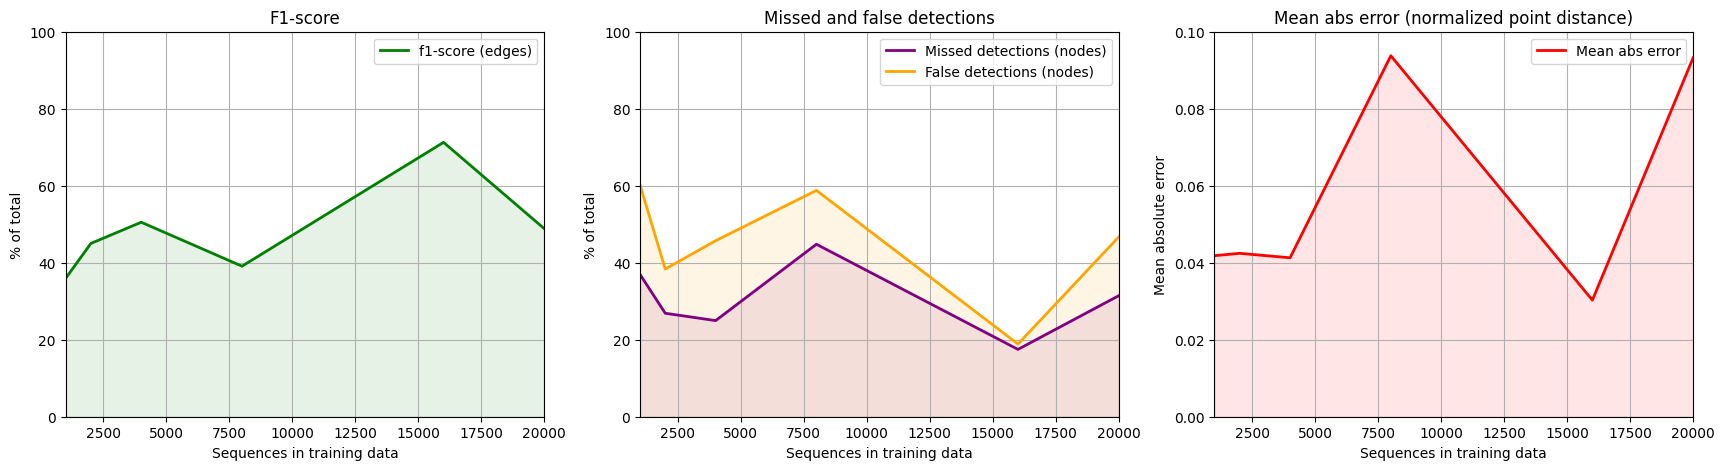

In [32]:
import pandas as pd
from matplotlib import pyplot as plt

    
#df = pd.DataFrame(metrics_list)

plt.figure(figsize=(21, 5))

data_amount = [1000, 2000, 4000, 8000, 16000, 20000]

plt.subplot(1, 3, 1)

plt.title("F1-score")

plt.plot(data_amount, df["f1-score"]*100, c="green", linewidth=2)
plt.fill_between(data_amount, df["f1-score"]*100, 0, color='green', alpha=.1)
plt.legend(["f1-score (edges)"])
plt.ylabel("% of total")
plt.xlabel("Sequences in training data")
plt.ylim([0,100])
plt.xlim([1000,20000])
plt.grid()

plt.subplot(1, 3, 2)
plt.title("Missed and false detections")

plt.plot(data_amount, df["md_mean"]*100, c="purple", linewidth=2)
plt.plot(data_amount, df["fd_mean"]*100, c="orange", linewidth=2)
plt.fill_between(data_amount, df["md_mean"]*100, 0, color='purple', alpha=.1)
plt.fill_between(data_amount, df["fd_mean"]*100, 0, color='orange', alpha=.1)
plt.legend(['Missed detections (nodes)', "False detections (nodes)"])
plt.ylabel("% of total")
plt.xlabel("Sequences in training data")
plt.ylim([0,100])
plt.xlim([1000,20000])
plt.grid()


plt.subplot(1, 3, 3)
plt.plot(data_amount, df["mae_mean"], c="red",linewidth=2)
plt.fill_between(data_amount, df["mae_mean"], 0, color='red', alpha=.1)
plt.legend(['Mean abs error'])
plt.ylabel("Mean absolute error")
plt.xlabel("Sequences in training data")
plt.ylim([0,0.1])
plt.xlim([1000,20000])
plt.grid()

plt.title("Mean abs error (normalized point distance)")

df.head(10)

df.to_csv("./data_amount_csv.csv")

#### With and without attention

In [6]:
class MultiheadAttention(pl.LightningModule):
    def __init__(
        self,
        max_t = 1, 
        softmax_factor = 1,
        number_of_heads = 1,
        num_filters = 10,
        **kwargs
    ):
        super(MultiheadAttention, self).__init__()

        self.max_t = max_t
        self.softmax_factor = softmax_factor
        self.number_of_heads = number_of_heads

        self.combine_time_dense = nn.Linear(num_filters, num_filters)

    def forward(self, latents, latents_frames):
        batch_size = latents.shape[0]
        timesteps = latents.shape[1]

        time_mask = self.mask(latents_frames, max_t=self.max_t)
        
        mask = time_mask

        eye = torch.eye(batch_size, dtype=torch.float32, device=time_mask.device)
        eye = eye.repeat_interleave(timesteps*latents.shape[2], dim=0)
        batch_mask = eye.repeat_interleave(timesteps*latents.shape[2], dim=1)

        #time_mask *= batch_mask
        
        # Edges between the supernodes:
        updated_latents, attention = self.multihead_time_attention(latents, self.softmax_factor, self.number_of_heads, mask)

        updated_latents = updated_latents.view(batch_size*timesteps, -1, updated_latents.shape[-1])

        return [updated_latents, attention]

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-5)
    
    def mask(self, supernode_times, max_t):
        supernode_times = supernode_times.view(-1, 1)
        m = torch.where(torch.abs(torch.transpose(supernode_times, 0, 1) - supernode_times) <= max_t, 1, 0)
        m = torch.where(torch.transpose(supernode_times, 0, 1) == supernode_times, torch.tensor(0, dtype=torch.int32), m)

        return m.float()
    
    def multihead_time_attention(self, latents, softmax_factor, number_of_heads, mask):

        number_of_filters = latents.shape[-1]

        projection_dim = number_of_filters // number_of_heads

        latents = latents.view(-1, number_of_heads, projection_dim)
        latents = latents.transpose(0, 1)

        nominator = torch.matmul(latents, latents.transpose(1, 2))
        denominator = torch.einsum('hi,hj->hij', torch.norm(latents, dim=2), torch.norm(latents, dim=2))

        attention = torch.div(nominator, denominator)  # Note: PyTorch's div function already handles division by zero
        attention += (1 - mask) * -10e9
        attention = torch.nn.functional.softmax(attention * softmax_factor, dim=-1)
        attention = torch.mean(attention, axis=0, keepdim=True)
        #attention = Sparsemax()(attention)

        add_eye = torch.eye(attention.shape[1], device=attention.device)
        updated_latents = torch.matmul(attention + add_eye, latents) / 2

        updated_latents = updated_latents.view(-1, number_of_filters)

        updated_latents = self.combine_time_dense(updated_latents)

        return updated_latents, attention

    def distance_matrix_heads(self, matrix_a, matrix_b):
        expanded_a = matrix_a.unsqueeze(2)
        expanded_b = matrix_b.unsqueeze(1)
        square_difference = torch.square(expanded_a - expanded_b)
        distances = torch.sum(square_difference, dim=3)
        distances = torch.sqrt(distances)

        return distances


class MultiEntityVariationalAutoEncoder(pl.LightningModule):
    def __init__(self, num_entities, beta=0.1, latent_dim=12, number_of_heads=1, softmax_tmp = 1, attention=True):
        super(MultiEntityVariationalAutoEncoder, self).__init__()

        self.num_entities = num_entities
        self.beta = beta
        self.latent_dim = latent_dim
        self.attention = attention

        actual_latent_dim = latent_dim * 2 

        self.time_attention = MultiheadAttention(number_of_heads=number_of_heads, num_entities=latent_dim-2, softmax_factor=softmax_tmp)

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(8, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, actual_latent_dim, 3, padding=1),
        )

        self.decoder_1 = nn.Sequential(
            nn.Conv2d(self.latent_dim + 1, 32, 1, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 32, 1, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 32, 1, padding=0),
        )

        self.decoder_2 = nn.Sequential(
            nn.Conv2d(32, 32, 1, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 32, 1, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 1, 1, padding=0),
        )

    

    def forward(self, x):
        true_batch_size = x.shape[0]
        timesteps = x.shape[1]

        batch_size = true_batch_size*timesteps

        x = x.view(batch_size, x.shape[2], x.shape[3], x.shape[4])

        y = self.encoder(x)

        mu = y[:, :self.latent_dim, :, :]
        logvar = y[:, self.latent_dim:, :, :]

        x_range = torch.arange(0, x.shape[3], device=x.device, dtype=torch.float32)
        y_range = torch.arange(0, x.shape[2], device=x.device, dtype=torch.float32)
        x_grid, y_grid = torch.meshgrid(x_range, y_range)

        std = torch.exp(0.5 * logvar)

        parametrization = torch.randn_like(std) * std + mu

        delta_xy_pred = parametrization[:, :2].view(batch_size, 2, -1)
        parametrization = parametrization[:, 2:].view(batch_size, self.latent_dim - 2, -1)
        

        # Calculate the KL divergence from the prior of gaussian distribution with mean 0 and std 1
        # to the posterior of the gaussian distribution with mean mu and std std
        # KL divergence is calculated as 0.5 * sum(1 + log(std^2) - mu^2 - std^2)

        kl_divergence = -0.5 * torch.sum(1 + logvar - mu**2 - std**2, dim=1)
        kl_divergence = kl_divergence.view(batch_size, -1)
        # find the i,j indices of the max value num_entities elements in the kl_divergence tensorimage_size
        # these indices will be used to select the num_entities most important entities

        top_kl_divergence, indices = torch.topk(kl_divergence, self.num_entities, dim=1)
        indices = indices.detach()
        intermediate_feature_map = None

        latents = torch.stack(
            [
                torch.stack(
                    [parametrization[batch_idx, :, idx] for idx in indices[batch_idx]]
                ) for batch_idx in range(batch_size)
            ]
        )

        
        times = torch.arange(0, timesteps, device=x.device, dtype=torch.int32)
        times = torch.unsqueeze(times.repeat(true_batch_size), -1).repeat(1, self.num_entities)

        times = times.view(true_batch_size, timesteps, latents.shape[1], -1)
        new_latents = latents.view(true_batch_size, timesteps, latents.shape[1], -1)

        new_latents, attention = self.time_attention(new_latents, times) # NOT SURE IF I SHOULD DO THIS HERE OR FURTHER DOWN

        if self.attention:
            latents = new_latents

        # repeat latents to match the size of input image
        # (batch_size, num_entities, latent_dim, 1, 1) -> (batch_size, num_entities, latent_dim, x.shape[2], x.shape[3]
        latents = latents[:, :, :, None, None].repeat(1, 1, 1, x.shape[2], x.shape[3])

        # grid channel is a tensor of size (batch_size, latent_dim, 2, x.shape[2], x.shape[3])
        # it contains the x and y coordinates of each pixel in the image
        grid_channel = torch.stack([x_grid, y_grid])[None, None]
        grid_channel = grid_channel.repeat(batch_size, self.num_entities, 1, 1, 1)

        # center the grid channel around the coordinates of the entities
        x_coord = indices // y.shape[3]
        y_coord = indices % y.shape[3]
        
        # add 0.5 to the coordinates to center the grid channel around the coordinates of the entities
        # scale the coordinates to match the size of the input image
        x_coord = (x_coord + 0.5) * x.shape[2] / y.shape[2]
        y_coord = (y_coord + 0.5) * x.shape[3] / y.shape[3]

        xy_coord = torch.stack([x_coord, y_coord], dim=2)[..., None, None]
        grid_channel = grid_channel - xy_coord

        # add the predicted delta_xy to the grid channel
        pred_delta_xy = torch.stack(
            [
                torch.stack(
                    [delta_xy_pred[batch_idx, :, idx] for idx in indices[batch_idx]]
                ) for batch_idx in range(batch_size)
            ]
        )[..., None, None]
        grid_channel = grid_channel + pred_delta_xy * 2

        r_channel = torch.sqrt(torch.sum(grid_channel**2, dim=2, keepdim=True))

        
        # concatenate the grid channel and the latents
        # (batch_size, num_entities, latent_dim + 2, x.shape[2], x.shape[3])
        intermediate_feature_map = torch.cat([latents, r_channel / 4, grid_channel / 4], dim=2)

        # DO IT ON THE INTERMEDIATE FEATURE MAP?

        # flatten batch and num_entities dimensions
        # (batch_size * num_entities, latent_dim + 2, x.shape[2], x.shape[3])
        intermediate_feature_map = intermediate_feature_map.view(
            batch_size * self.num_entities, -1, x.shape[2], x.shape[3]
        )

        decoded_feature_map = self.decoder_1(intermediate_feature_map)

        # unflatten batch and num_entities dimensions
        # (batch_size, num_entities, 32, x.shape[2], x.shape[3])
        decoded_feature_map = decoded_feature_map.view(
            batch_size, self.num_entities, -1, x.shape[2], x.shape[3]
        )
        
        # reduce entity dimension by taking max
        combined_entities = torch.max(decoded_feature_map, dim=1)[0]

        y = self.decoder_2(combined_entities)

        y = y.view(true_batch_size, timesteps, x.shape[1], x.shape[2], x.shape[3])

        return [y, indices, kl_divergence, delta_xy_pred, mu, logvar, attention]

    def loss_function(self, x, x_hat, kl_divergence, mu, logvar):
        # Reconstruction loss
        reconstruction_loss = F.mse_loss(x_hat, x)
        # KL divergence loss
        kl_divergence_loss = torch.mean(torch.sum(kl_divergence, dim=1), dim=0)

        # MN weighting
        weight_MN = x.shape[1] * x.shape[2] * x.shape[3] / 12

        # Total loss
        loss = reconstruction_loss + kl_divergence_loss * weight_MN * self.beta

        return {
            "loss": loss,
            "reconstruction_loss": reconstruction_loss,
            "KLD": kl_divergence_loss,
            "weighted_KLD": kl_divergence_loss * weight_MN * self.beta,
        }


class MEVAE(pl.LightningModule):
    def __init__(self, num_entities, beta=0.1, number_of_heads = 1, softmax_tmp = 1, attention=True):
        super().__init__()
        self.model = MultiEntityVariationalAutoEncoder(num_entities, beta, number_of_heads=number_of_heads, attention=attention)

    def forward(self, x):
        return self.model(x)

    def training_step(self, x, batch_idx):
        x_hat, indices, kl_divergence, xy, mu, logvar, attention = self(x)
        kl_divergence = [kld[idx] for kld, idx in zip(kl_divergence, indices)]

        kl_divergence = torch.stack(kl_divergence)
        loss_dict = self.model.loss_function(x, x_hat, kl_divergence, mu, logvar)
        self.log_dict(loss_dict, on_epoch=True, prog_bar=True)
        return loss_dict["loss"]

    def validation_step(self, x, batch_idx):
        x_hat, indices, kl_divergence, xy, mu, logvar = self(x)
        kl_divergence = [kld[idx] for kld, idx in zip(kl_divergence, indices)]

        kl_divergence = torch.stack(kl_divergence)

        loss_dict = self.model.loss_function(x, x_hat, kl_divergence, mu, logvar)
        # self.log_dict(loss_dict, on_step=True, on_epoch=True, prog_bar=True)
        return loss_dict["loss"]

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=2e-4)

In [32]:
import numpy as np
import IPython.display as ipd


repeats = 1
num_entities = 10
softmax_tmp = 10

attention = False

#model = MEVAE(num_entities=num_entities, beta=0, number_of_heads=1, softmax_tmp=softmax_tmp, attention=attention)
trainer = pl.Trainer(max_epochs=100, callbacks=[BetaCallback(), PlotCallback()])
trainer.fit(model, train_loader)


<Figure size 640x480 with 0 Axes>

Epoch 99: 100%|██████████| 100/100 [00:06<00:00, 16.04it/s, v_num=869, loss_step=0.0186, reconstruction_loss_step=0.0185, KLD_step=710.0, weighted_KLD_step=0.000152, loss_epoch=0.016, reconstruction_loss_epoch=0.0158, KLD_epoch=717.0, weighted_KLD_epoch=0.000153] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 100/100 [00:06<00:00, 16.00it/s, v_num=869, loss_step=0.0186, reconstruction_loss_step=0.0185, KLD_step=710.0, weighted_KLD_step=0.000152, loss_epoch=0.016, reconstruction_loss_epoch=0.0158, KLD_epoch=717.0, weighted_KLD_epoch=0.000153]


/tmp/ipykernel_4168971/1011003120.py:123: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  combine_map = (np.where(np.array(distances) < combine_radius, 1, 0).astype(np.bool) &  matrix.astype(np.bool)).astype(np.int32)
/tmp/ipykernel_4168971/1011003120.py:195: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp = np.sum(gt_attention.astype(np.bool) & bin

{'mae_mean': 0.00592859919063011, 'fd_mean': 0.02041666666666667, 'md_mean': 0.06625, 'precision': 0.8338509316770186, 'recall': 0.829984544049459, 'f1-score': 0.8319132455460883}


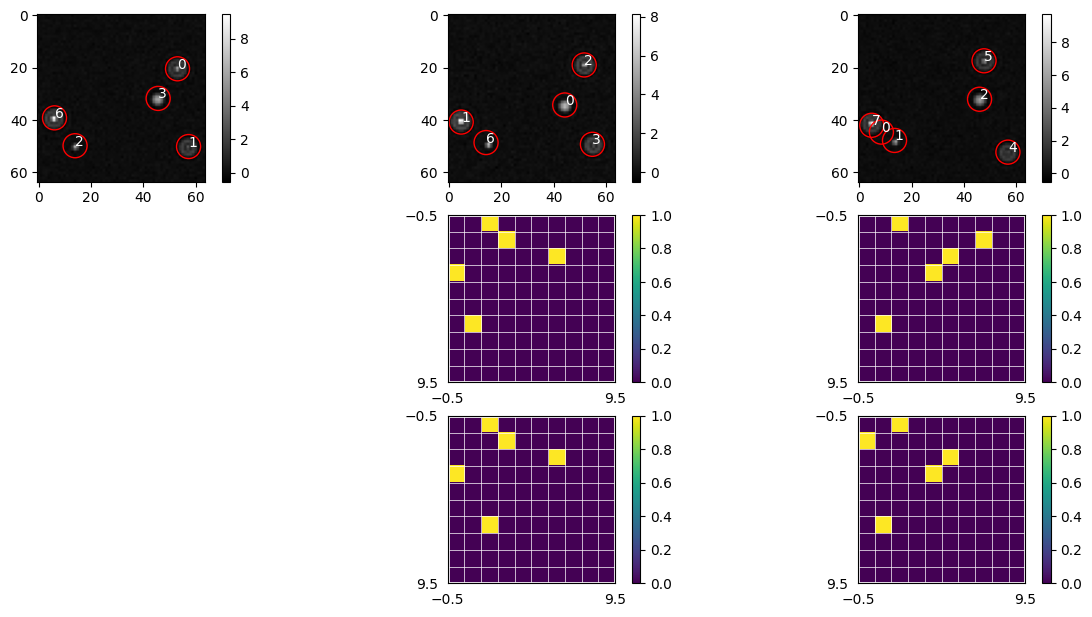

In [33]:

metrics = run_test(model, 4, num_entities=num_entities, plot_num=2)
print(metrics)

In [69]:
import pandas as pd
df_att = pd.DataFrame(metrics_list_attention)
df_noatt = pd.DataFrame(metrics_list_no_attention)

#df_att.to_csv("./att.csv")
#df_noatt.to_csv("./noatt.csv")

In [70]:
df_att.head(10)

,mae_mean,fd_mean,md_mean,precision,recall,f1-score
0,0.003686,0.033,0.186833,0.694828,0.680743,0.687713


In [71]:
df_noatt.head(10)

,mae_mean,fd_mean,md_mean,precision,recall,f1-score
0,0.173189,0.827188,0.519,0.107684,0.390196,0.168787


In [42]:
print(np.mean(df_att["mae_mean"]))
print(np.mean(df_att["fd_mean"]))
print(np.mean(df_att["md_mean"]))
print(np.mean(df_att["recall"]))
print(np.mean(df_att["f1-score"]))

print()

print(np.mean(df_noatt["mae_mean"]))
print(np.mean(df_noatt["fd_mean"]))
print(np.mean(df_noatt["md_mean"]))
print(np.mean(df_noatt["recall"]))
print(np.mean(df_noatt["f1-score"]))



0.13730085983412635
0.6534464285714287
0.40441666666666665
0.3909541511771995
0.25465464892694406

0.08926610510916023
0.5681428571428572
0.4439166666666667
0.5297358082583389
0.35974665596733085


#### Trying on real data

In [117]:
def run_test(model, test_set, combine_radius, plot_num = 0, num_entities=10):

    for i_seq, x in enumerate(test_set):

        #x = x[1:2]
        #x = torch.unsqueeze(x, dim=0)
        x = x.to(model.device)
        x_hat, indices, kl_divergence, xy, mu, logvar, attention = model(x)

        x = x.detach().cpu().numpy()
        
        if i_seq == plot_num:
            plt.figure(figsize=(15, 10))


        n = [i for i in range(num_entities)]

        combine_map_v = []
        remove_map_v = []
        xp_v = []
        yp_v = []
        for i in range(mu.shape[0]):

            xy_mu = mu[i, :2].view(2, -1).detach().cpu().numpy()

            flatind = indices[i, :].detach().cpu().numpy()

            mu_obj = mu[i, :].view(mu.shape[1], -1)[:, flatind]
            
            xy = xy_mu[:, flatind]
            
            row, col = np.unravel_index(flatind, (16, 16))
            xp = (row + .5) * 4 - xy[0, :] * 2
            yp = (col + .5) * 4 - xy[1, :] * 2

            xp_v.append(xp)
            yp_v.append(yp)

            distances = []
            for j in range(xp.shape[0]):
                distance_r = []
                for k in range(xp.shape[0]):
                    if j == k:
                        distance_r.append(0)
                        continue
                    dist = distance(xp[j], xp[k], yp[j], yp[k])
                    distance_r.append(dist)
                distances.append(distance_r)
            distances = np.array(distances)

            # Create the combin map
            row_indices, col_indices = np.indices(distances.shape)
            matrix = np.zeros(distances.shape)
            matrix[row_indices - col_indices <= 0] = 1

            combine_map = (np.where(np.array(distances) < combine_radius, 1, 0).astype(np.bool) &  matrix.astype(np.bool)).astype(np.int32)

            remove_map = np.sum(combine_map - np.eye(combine_map.shape[0]), axis=0)

            combine_map_v.append(combine_map)
            remove_map_v.append(remove_map)

        for i in range(mu.shape[0]):
            xp = xp_v[i]
            yp = yp_v[i]

            if i_seq == plot_num:
                plt.subplot(4, 3, i+1)
                plt.imshow(x[0, i, 0, :, :], cmap="gray")
                plt.colorbar()
                plt.scatter(yp[~remove_map_v[i].astype(np.bool)], xp[~remove_map_v[i].astype(np.bool)], marker="o", s=300, edgecolor="r", facecolor="none")
                for j, txt in enumerate(n):
                    if remove_map_v[i][j]:
                        continue
                    plt.annotate(txt, (yp[j], xp[j]), color='white')


            if i == 0:
                continue

            attention_to_next = attention[0, (i-1)*num_entities:i*num_entities, i*num_entities:(i+1)*num_entities]
            new_attention = combine_nodes(attention_to_next, combine_map_v, remove_map_v, i-1)

            max_indices = np.argmax(new_attention, axis=1)
            binary_attention = np.zeros_like(new_attention)
            binary_attention[np.arange(new_attention.shape[0]), max_indices] = 1
            binary_attention *= np.where(new_attention > 0, 1, 0)


            if i_seq == plot_num:

                plt.subplot(4, 3, i+7)
                plt.imshow(binary_attention)
                plt.xticks(np.arange(-.5, attention_to_next.shape[1], 1), minor=True)
                plt.yticks(np.arange(-.5, attention_to_next.shape[1], 1), minor=True)
                plt.grid(which='minor', color='w', linestyle='-', linewidth=0.5)
                plt.tick_params(which='minor', bottom=False, left=False)

                plt.xticks(np.arange(-.5, attention_to_next.shape[1], num_entities), minor=False)
                plt.yticks(np.arange(-.5, attention_to_next.shape[1], num_entities), minor=False)
                plt.grid(which='major', color='w', linestyle='-', linewidth=2)
                plt.tick_params(which='major', bottom=False, left=False)
                plt.colorbar()

    return

In [159]:
import numpy as np
import glob
import tifffile
import torch
import importlib


paths = "/data/graph_track_data/Fluo-N2DL-HeLa/01/*.tif"
paths = glob.glob(paths)

images = [
    tifffile.imread(path) for path in paths
]

# background = np.mean(images, axis=0, keepdims=True)

# training_images = images

training_images = np.array(images)
training_images = training_images / 255
training_images = training_images - np.mean(training_images)
#training_images = training_images / np.std(training_images, axis=(1, 2), keepdims=True) * 0.5


training_images = torch.from_numpy(training_images).float()[:, None]
training_images = training_images[:, :, ::4, ::4]
training_images = training_images[:90, :, :64, :64]


In [160]:
training_images.shape

torch.Size([90, 1, 64, 64])

In [161]:
tmp = training_images.view(3, 30, 1, 64, 64)
tmp = tmp.permute(1, 0, 2, 3, 4)

tmp.shape

torch.Size([30, 3, 1, 64, 64])

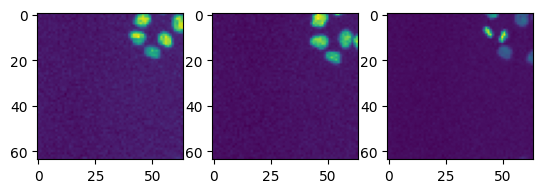

In [162]:
plt.subplot(1,3, 1)
plt.imshow(tmp.numpy()[0,0,0,:,:])
plt.subplot(1,3, 2)
plt.imshow(tmp.numpy()[0,1,0,:,:])
plt.subplot(1,3, 3)
plt.imshow(tmp.numpy()[0,2,0,:,:])


In [5]:
import torch

train, test = torch.utils.data.random_split(tmp, [0.9, 0.10])

# create dataloaders
train_loader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=True)

NameError: name 'tmp' is not defined

In [194]:
model = MEVAE(num_entities=15, softmax_tmp=10, beta=0, number_of_heads=1)
trainer = pl.Trainer(max_epochs=300, callbacks=[BetaCallback(), PlotCallback()])
trainer.fit(model, train_loader)


<Figure size 640x480 with 0 Axes>

Epoch 299: 100%|██████████| 14/14 [00:00<00:00, 31.85it/s, v_num=901, loss_step=0.0286, reconstruction_loss_step=0.0267, KLD_step=1.24e+3, weighted_KLD_step=0.00197, loss_epoch=0.038, reconstruction_loss_epoch=0.036, KLD_epoch=1.27e+3, weighted_KLD_epoch=0.00201]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 14/14 [00:00<00:00, 30.46it/s, v_num=901, loss_step=0.0286, reconstruction_loss_step=0.0267, KLD_step=1.24e+3, weighted_KLD_step=0.00197, loss_epoch=0.038, reconstruction_loss_epoch=0.036, KLD_epoch=1.27e+3, weighted_KLD_epoch=0.00201]


/tmp/ipykernel_4168971/522914631.py:56: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  combine_map = (np.where(np.array(distances) < combine_radius, 1, 0).astype(np.bool) &  matrix.astype(np.bool)).astype(np.int32)
/tmp/ipykernel_4168971/522914631.py:71: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.scatter(yp[~remove_map_v[i].astype(np.bool)], 

Epoch 300: 100%|██████████| 4/4 [15:24:39<00:00, 13869.77s/it, v_num=885, loss_step=0.111, reconstruction_loss_step=0.104, KLD_step=4.41e+3, weighted_KLD_step=0.00706, loss_epoch=0.104, reconstruction_loss_epoch=0.0973, KLD_epoch=4.46e+3, weighted_KLD_epoch=0.00706]


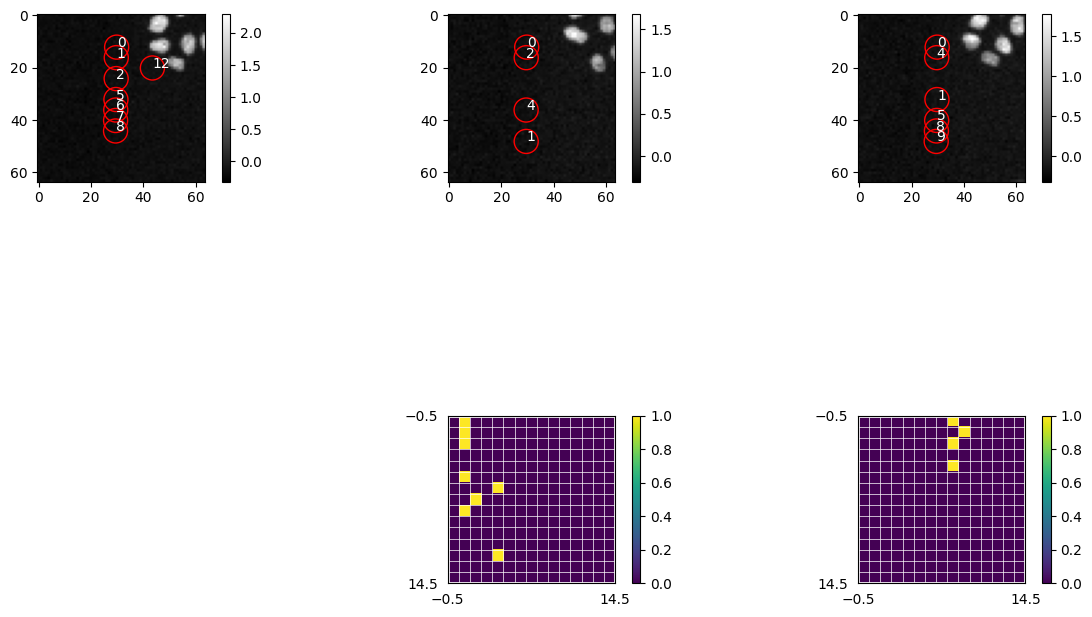

In [193]:
run_test(model, test_loader, 4, plot_num = 1, num_entities=15)

#### Trying to get the best model

In [56]:
train_loader, test_loader, test, test_centroids, test_edges = generate_data(sequence_length=5)


Generating Training data
0
100
200
300
400
500


In [18]:
metrics = []
attention = True
num_entities = 10
softmax_tmp = 10



model = MEVAE(num_entities=num_entities, beta=0, number_of_heads=1, softmax_tmp=softmax_tmp, attention=attention)
trainer = pl.Trainer(max_epochs=100, callbacks=[BetaCallback(), PlotCallback()])
trainer.fit(model, train_loader)



<Figure size 640x480 with 0 Axes>

Epoch 99: 100%|██████████| 100/100 [00:28<00:00,  3.57it/s, v_num=903, loss_step=0.0285, reconstruction_loss_step=0.028, KLD_step=475.0, weighted_KLD_step=0.000508, loss_epoch=0.0264, reconstruction_loss_epoch=0.0259, KLD_epoch=462.0, weighted_KLD_epoch=0.000494]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 100/100 [00:28<00:00,  3.56it/s, v_num=903, loss_step=0.0285, reconstruction_loss_step=0.028, KLD_step=475.0, weighted_KLD_step=0.000508, loss_epoch=0.0264, reconstruction_loss_epoch=0.0259, KLD_epoch=462.0, weighted_KLD_epoch=0.000494]


/tmp/ipykernel_799039/1011003120.py:123: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  combine_map = (np.where(np.array(distances) < combine_radius, 1, 0).astype(np.bool) &  matrix.astype(np.bool)).astype(np.int32)
/tmp/ipykernel_799039/1011003120.py:195: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp = np.sum(gt_attention.astype(np.bool) & binar

ValueError: num must be an integer with 1 <= num <= 12, not 13

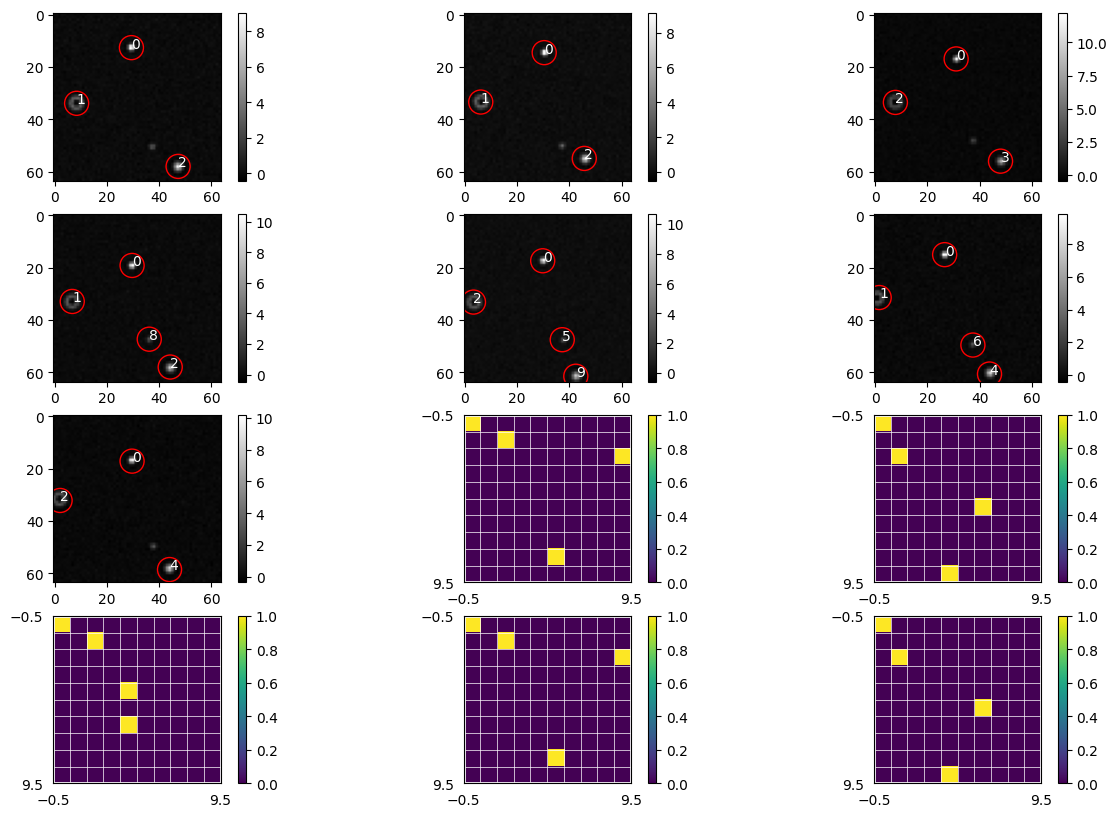

In [19]:
metrics = run_test(model, 4, num_entities=num_entities, plot_num=15)
print(metrics)

In [54]:
attention = True
num_entities = 10
softmax_tmp = 10
model = MEVAE(num_entities=num_entities, beta=0, number_of_heads=1, softmax_tmp=softmax_tmp)
model.load_state_dict(torch.load("../state_dicts/best-so-far-500.pth"))

<All keys matched successfully>

In [53]:
torch.save(model.state_dict(), "../state_dicts/best-so-far.pth")

#### Long plot

In [35]:
def run_test(model, combine_radius, plot_num = 0, num_entities=10):

    mse_total = []
    false_detections_total = []
    missed_detections_total = []
    tp_total = []
    fp_total = []
    tn_total = []
    fn_total = []
    for i_seq, x in enumerate(test):

        gt_nodes = test_centroids[i_seq]

        #x = x[1:2]
        x = torch.unsqueeze(x, dim=0)
        x = x.to(model.device)
        x_hat, indices, kl_divergence, xy, mu, logvar, attention = model(x)

        x = x.detach().cpu().numpy()

        n = [i for i in range(num_entities)]

        combine_map_v = []
        remove_map_v = []
        xp_v = []
        yp_v = []
        for i in range(mu.shape[0]):

            xy_mu = mu[i, :2].view(2, -1).detach().cpu().numpy()

            flatind = indices[i, :].detach().cpu().numpy()

            mu_obj = mu[i, :].view(mu.shape[1], -1)[:, flatind]
            
            xy = xy_mu[:, flatind]
            
            row, col = np.unravel_index(flatind, (16, 16))
            xp = (row + .5) * 4 - xy[0, :] * 2
            yp = (col + .5) * 4 - xy[1, :] * 2

            xp_v.append(xp)
            yp_v.append(yp)

            if i_seq == plot_num:
                plt.figure(figsize=(10, 10))

            distances = []
            for j in range(xp.shape[0]):
                distance_r = []
                for k in range(xp.shape[0]):
                    if j == k:
                        distance_r.append(0)
                        continue
                    dist = distance(xp[j], xp[k], yp[j], yp[k])
                    distance_r.append(dist)
                distances.append(distance_r)
            distances = np.array(distances)

            # Create the combin map
            row_indices, col_indices = np.indices(distances.shape)
            matrix = np.zeros(distances.shape)
            matrix[row_indices - col_indices <= 0] = 1

            combine_map = (np.where(np.array(distances) < combine_radius, 1, 0).astype(np.bool) &  matrix.astype(np.bool)).astype(np.int32)

            remove_map = np.sum(combine_map - np.eye(combine_map.shape[0]), axis=0)

            combine_map_v.append(combine_map)
            remove_map_v.append(remove_map)

        for i in range(mu.shape[0]):
            xp = xp_v[i]
            yp = yp_v[i]
            gt_nodes_timestep = np.array(gt_nodes[i])

            if i_seq == plot_num:
                if i > 0:
                    scatter.remove()
                    show.remove()
                #plt.subplot(2, 1, 1)
                show = plt.imshow(x[0, i, 0, :, :], cmap="gray")
                #plt.colorbar()
                scatter = plt.scatter(yp[~remove_map_v[i].astype(np.bool)], xp[~remove_map_v[i].astype(np.bool)], marker="o", s=300, edgecolor="r", facecolor="none")
                for j, txt in enumerate(n):
                    if remove_map_v[i][j]:
                        continue
                    plt.annotate(txt, (yp[j], xp[j]), color='white')
                #plt.scatter(gt_nodes_timestep[:,1]*image_size, gt_nodes_timestep[:,0]*image_size, color='g')

            # Calculate node metrics
            xp_filtred = xp + remove_map_v[i]*1000
            yp_filtred = yp + remove_map_v[i]*1000

            distances = distance_matrix(np.array([xp_filtred/image_size, yp_filtred/image_size]), gt_nodes_timestep)
            min_distance = np.argmin(distances, axis=0)
            min_distance_2 = np.argmin(distances, axis=1)

            
            tn = 0
            tps = []
            missed_detections = 0
            false_detections = 0
            true_detections = 0
            for i_dist, dist_1 in enumerate(min_distance):
                if i_dist == min_distance_2[dist_1]:
                    tps.append(i_dist)
                else:
                    missed_detections += 1

            for i_dist, dist_2 in enumerate(min_distance_2):
                if remove_map_v[i][i_dist]:
                    continue
                if i_dist == min_distance[dist_2]:
                    true_detections += 1

                else:
                    false_detections += 1

            se = np.min(distances, axis=0)[tps]
            mse = np.mean(se)

            # Calculate attention metrics
            if i == 0:
                if i_seq == plot_num:
                    plt.savefig(f'../results/gif/fig_{i}.png')
                last_mapping = min_distance
                continue

            attention_to_next = attention[0, (i-1)*num_entities:i*num_entities, i*num_entities:(i+1)*num_entities]
            new_attention = combine_nodes(attention_to_next, combine_map_v, remove_map_v, i-1)

            gt_attention = np.zeros_like(new_attention)
            gt_attention[last_mapping, min_distance] += 1

            max_indices = np.argmax(new_attention, axis=1)
            binary_attention = np.zeros_like(new_attention)
            binary_attention[np.arange(new_attention.shape[0]), max_indices] = 1
            binary_attention *= np.where(new_attention > 0, 1, 0)


            tp = np.sum(gt_attention.astype(np.bool) & binary_attention.astype(np.bool))
            fp = np.sum(binary_attention.astype(np.bool)) - tp
            tn = np.sum(~gt_attention.astype(np.bool) & ~binary_attention.astype(np.bool))
            fn = np.sum(~binary_attention.astype(np.bool)) - tn

            mse_total.append(mse)
            false_detections_total.append(false_detections/(false_detections+true_detections))
            missed_detections_total.append(missed_detections/(min_distance.shape[0]))

            tp_total.append(tp)
            fp_total.append(fp)
            tn_total.append(tn)
            fn_total.append(fn)

            last_mapping = min_distance

            if i_seq == plot_num:
                cols = np.argmax(binary_attention, axis=1)
                for i_prev, i_curr in enumerate(cols):
                    if remove_map_v[i-1][i_prev] or remove_map_v[i][i_curr]:
                        continue
                    print(f"{i_prev}:{i_curr}")
                    x_line = [xp_v[i-1][i_prev], xp_v[i][i_curr]]
                    y_line = [yp_v[i-1][i_prev], yp_v[i][i_curr]]

                    plt.plot(y_line, x_line, c='b')
                
                plt.savefig(f'../results/gif/fig_{i}.png')


                #plt.subplot(2, 1, 2)
                #plt.imshow(binary_attention)
                #plt.xticks(np.arange(-.5, attention_to_next.shape[1], 1), minor=True)
                #plt.yticks(np.arange(-.5, attention_to_next.shape[1], 1), minor=True)
                #plt.grid(which='minor', color='w', linestyle='-', linewidth=0.5)
                #plt.tick_params(which='minor', bottom=False, left=False)

                #plt.xticks(np.arange(-.5, attention_to_next.shape[1], num_entities), minor=False)
                #plt.yticks(np.arange(-.5, attention_to_next.shape[1], num_entities), minor=False)
                #plt.grid(which='major', color='w', linestyle='-', linewidth=2)
                #plt.tick_params(which='major', bottom=False, left=False)
                #plt.colorbar()

            #if i == 3: 
            #    break


    mae_mean = np.mean(np.array(mse_total))
    fd_mean = np.mean(np.array(false_detections_total))
    md_mean = np.mean(np.array(missed_detections_total))

    tp_mean = np.mean(np.array(tp_total))
    fp_mean = np.mean(np.array(fp_total))
    tn_mean = np.mean(np.array(tn_total))
    fn_mean = np.mean(np.array(fn_total))

    precision = tp_mean/(tp_mean + fp_mean)
    recall = tp_mean/(tp_mean + fn_mean)

    f1 = 2*precision*recall/(precision+recall)

    return {
        "mae_mean": mae_mean,
        "fd_mean": fd_mean,
        "md_mean": md_mean,
        "precision": precision,
        "recall": recall,
        "f1-score": f1
        }

In [19]:
metrics = []
attention = True
num_entities = 10
softmax_tmp = 10


model = MEVAE(num_entities=num_entities, beta=0, number_of_heads=1, softmax_tmp=softmax_tmp, attention=attention)
trainer = pl.Trainer(max_epochs=100, callbacks=[BetaCallback(), PlotCallback()])
trainer.fit(model, train_loader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name  | Type                              | Params
------------------------------------------------------------
0 | model | MultiEntityVariationalAutoEncoder | 80.0 K
------------------------------------------------------------
80.0 K    Trainable params
0         Non-trainable params
80.0 K    Total params
0.320     Total estimated model params size (MB)


Epoch 0:   0%|          | 0/100 [00:00<?, ?it/s] 

Epoch 0: 100%|██████████| 100/100 [00:37<00:00,  2.67it/s, v_num=944, loss_step=0.199, reconstruction_loss_step=0.199, KLD_step=5.33e+3, weighted_KLD_step=0.000]

NameError: name 'ipd' is not defined

/tmp/ipykernel_90445/1384815890.py:64: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  combine_map = (np.where(np.array(distances) < combine_radius, 1, 0).astype(np.bool) &  matrix.astype(np.bool)).astype(np.int32)
/tmp/ipykernel_90445/1384815890.py:141: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp = np.sum(gt_attention.astype(np.bool) & binary_a

0:1
2:0
0:0
1:1
0:0
1:1
0:0
1:0
0:0
2:1
0:1
1:0
0:1
1:0
0:0
1:1
0:1
1:0
0:0
1:2
8:2
0:0
2:1
0:0
1:1
0:0
1:1
9:9
0:0
1:1
9:8
0:0
1:2
8:2
0:0
2:1
0:0
1:1
0:1
1:0
9:0
0:0
1:1
{'mae_mean': 0.0024540072382180987, 'fd_mean': 0.07519924812030075, 'md_mean': 0.05755263157894736, 'precision': 0.7985795454545455, 'recall': 0.8435108777194299, 'f1-score': 0.8204304998175848}


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

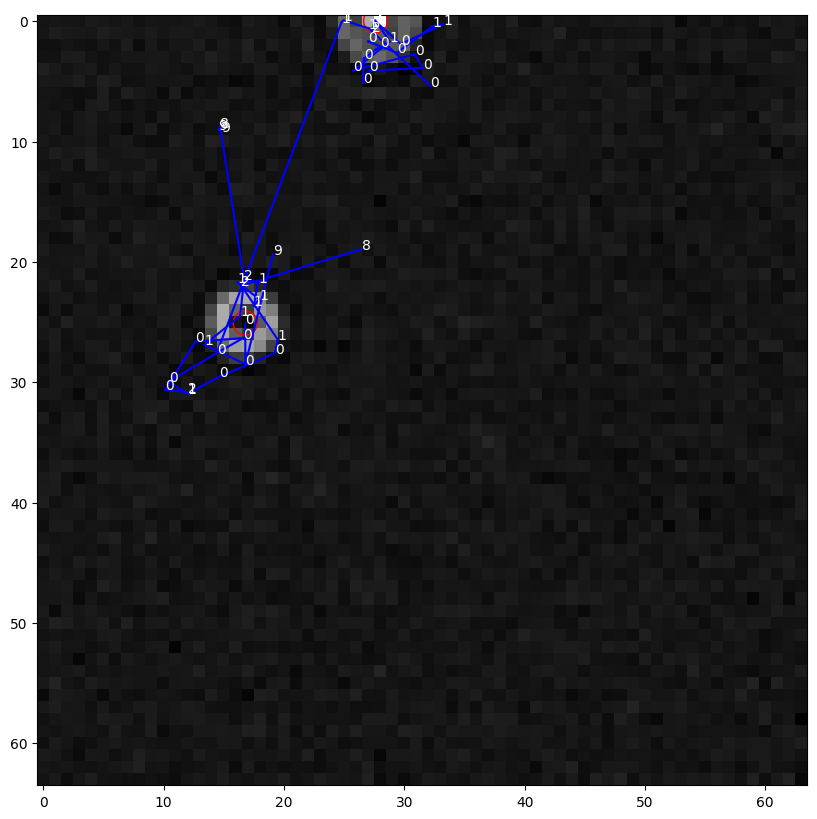

In [55]:
metrics = run_test(model, 4, num_entities=10, plot_num=25)
print(metrics)